In [15]:
import os
import git
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import math

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True

In [16]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "draft_plots")
main_df = main_df.copy()
np.random.seed(0)

In [17]:
def generate_hull_plots(temp_df):
    temp_df = temp_df.copy()
    temp_df = temp_df[temp_df['hull'].notna()]
    all_points = np.concatenate([np.array(hull.points[hull.vertices]) for hull in temp_df['hull']])
    x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
    y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
    if ZOOM:
        x_min, x_max = 0, 1
        y_min, y_max = 0, 1
    channels = temp_df["channel"].unique()
    orientations = temp_df["orientation"].unique()

    if len(ORIENTATION) > 3:
        n_directions = len(ORIENTATION)
        n_rows = 3
        n_cols = math.ceil(n_directions / n_rows)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)
    else:
        fig, axes = plt.subplots(len(channels), len(orientations), figsize=(6 * len(orientations), 5 * len(channels)), squeeze=False)

    for i, channel in enumerate(channels):
        for j, orientation in enumerate(orientations):
            
            if len(ORIENTATION) > 3:
                i, j = divmod(j, n_cols)
            ax = axes[i, j]
            if orientation is np.nan:
                subset = temp_df[(temp_df["channel"] == channel)]
            elif channel is np.nan:
                subset = temp_df[(temp_df["orientation"] == orientation)]
            elif orientation not in temp_df["orientation"].unique():
                continue
            elif channel not in temp_df["channel"].unique():
                continue
            else:
                subset = temp_df[(temp_df["channel"] == channel) & (temp_df["orientation"] == orientation)]
            if subset.empty:
                ax.set_title(f"{channel} - {orientation}\n(No Data)")
                ax.axis('off')
                continue
            max_group = subset["group"].astype(int).max()
            colors = plt.cm.viridis(np.linspace(0.3, 1, max_group))
            for _, row in subset.iterrows():
                group = int(row['group'])
                hull = row['hull']
                hull_points = np.array(hull.points[hull.vertices])
                color = colors[group - 1]
                kind = "Group"  # or set as needed
                ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.3, label=f'{kind} {group}')
                ax.plot(hull_points[:, 0], hull_points[:, 1], color=color)
                # Close the hull
                ax.plot([hull_points[-1, 0], hull_points[0, 0]], [hull_points[-1, 1], hull_points[0, 1]], color=color)

            # Uncomment and define roi_points, roi_hull if you want to plot ROI
            ax.plot(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], 'r--', lw=2, label='ROI Convex Hull')
            ax.fill(roi_points[roi_hull.vertices, 0], roi_points[roi_hull.vertices, 1], color='red', alpha=0.1)
            ax.plot([roi_points[roi_hull.vertices[-1], 0], roi_points[roi_hull.vertices[0], 0]],
                    [roi_points[roi_hull.vertices[-1], 1], roi_points[roi_hull.vertices[0], 1]],'r--', lw=2)

            if orientation is np.nan:
                ax.set_title(f"{channel}")
            elif channel is np.nan:
                ax.set_title(f"{orientation}")
            else:
                ax.set_title(f"{channel} - {orientation}")
            ax.set_xlabel('r')
            ax.set_ylabel('1/beta')
            ax.legend()
            ax.grid()
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)

    plt.suptitle(f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform", fontsize=16, y=0.94)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

    if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"Region Reporting for {SUBSET} {DATASET} - {TRANSFORM} Transform.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

# ROI

In [18]:
r_shade_roi = np.linspace(0.01, 4, 100)
eta_shade_roi = np.linspace(-0.1, 0.1, 100)
beta_shade_roi = (eta_shade_roi + 1.5)/r_shade_roi
r_roi_mesh, eta_roi_mesh = np.meshgrid(r_shade_roi, eta_shade_roi)
beta_roi_mesh = (eta_roi_mesh + 1.5) / r_roi_mesh
roi_points = np.column_stack([r_roi_mesh.ravel(), (1 / beta_roi_mesh).ravel()])
roi_hull = ConvexHull(roi_points)

# Remote Sensing

## pastis

### Wavelet

In [19]:
DATASET = "pastis"
SUBSET = "full"
TRANSFORM = "wavelet"
ORIENTATION = ["horizVert", "diagonal"]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True


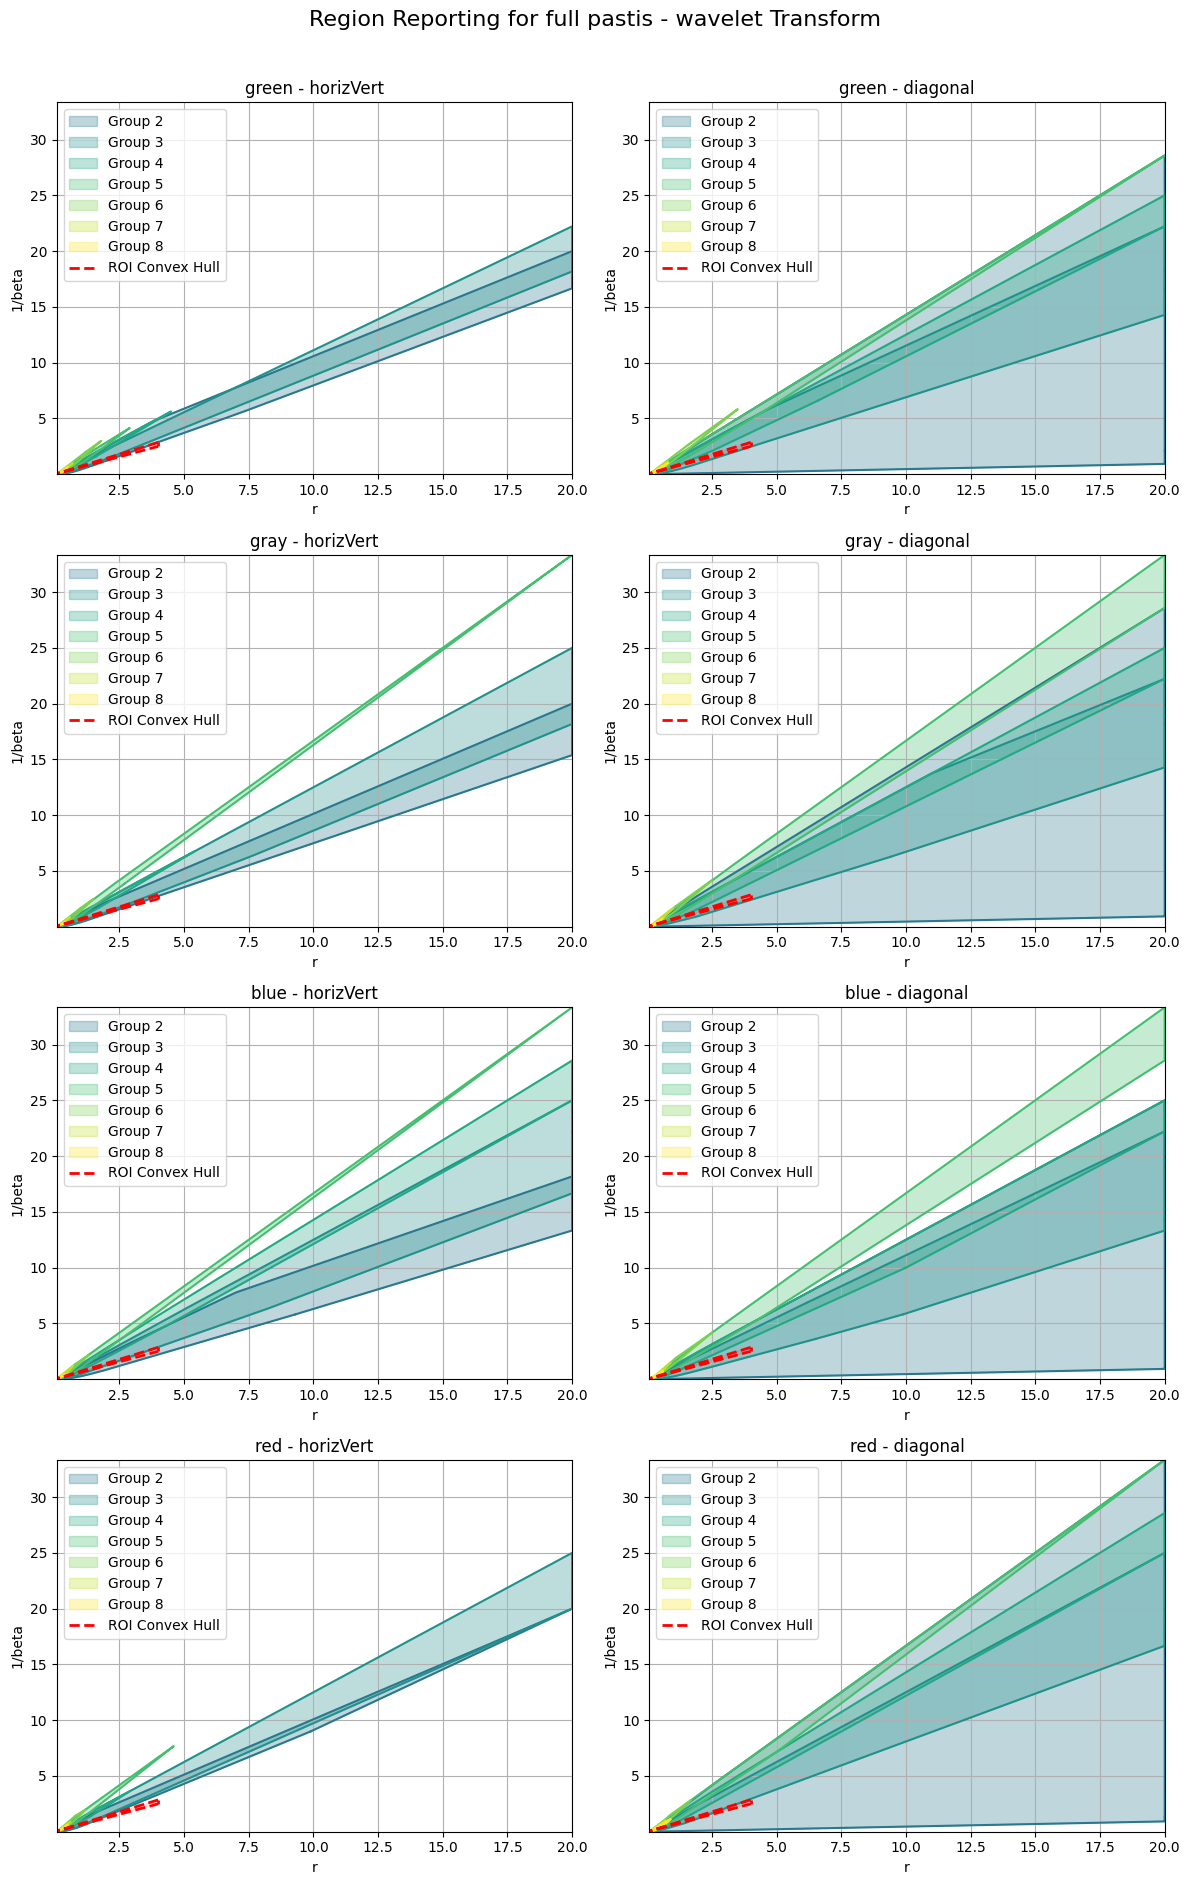

In [20]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

### Fourier

In [21]:
DATASET = "pastis"
SUBSET = "full"
TRANSFORM = "fourier"
ORIENTATION = [np.nan]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

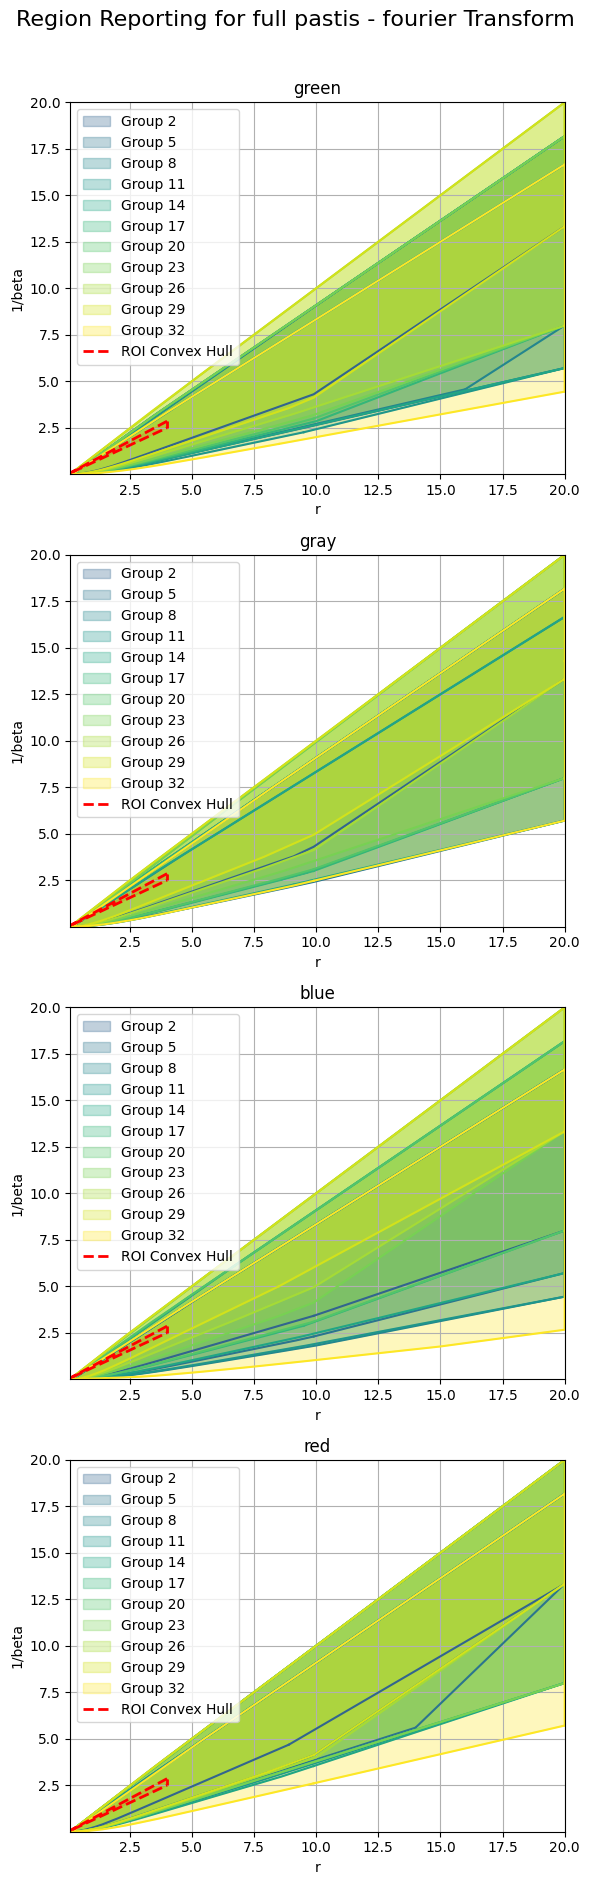

In [22]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

### Learned

In [23]:
DATASET = "pastis"
SUBSET = "full"
TRANSFORM = "learned"
ORIENTATION = ["single_edge", "multi_edge", "eye", "dual_color", "inside_out", "misc"]
CHANNEL = [np.nan]
ZOOM  = False
PASS_ONLY = True


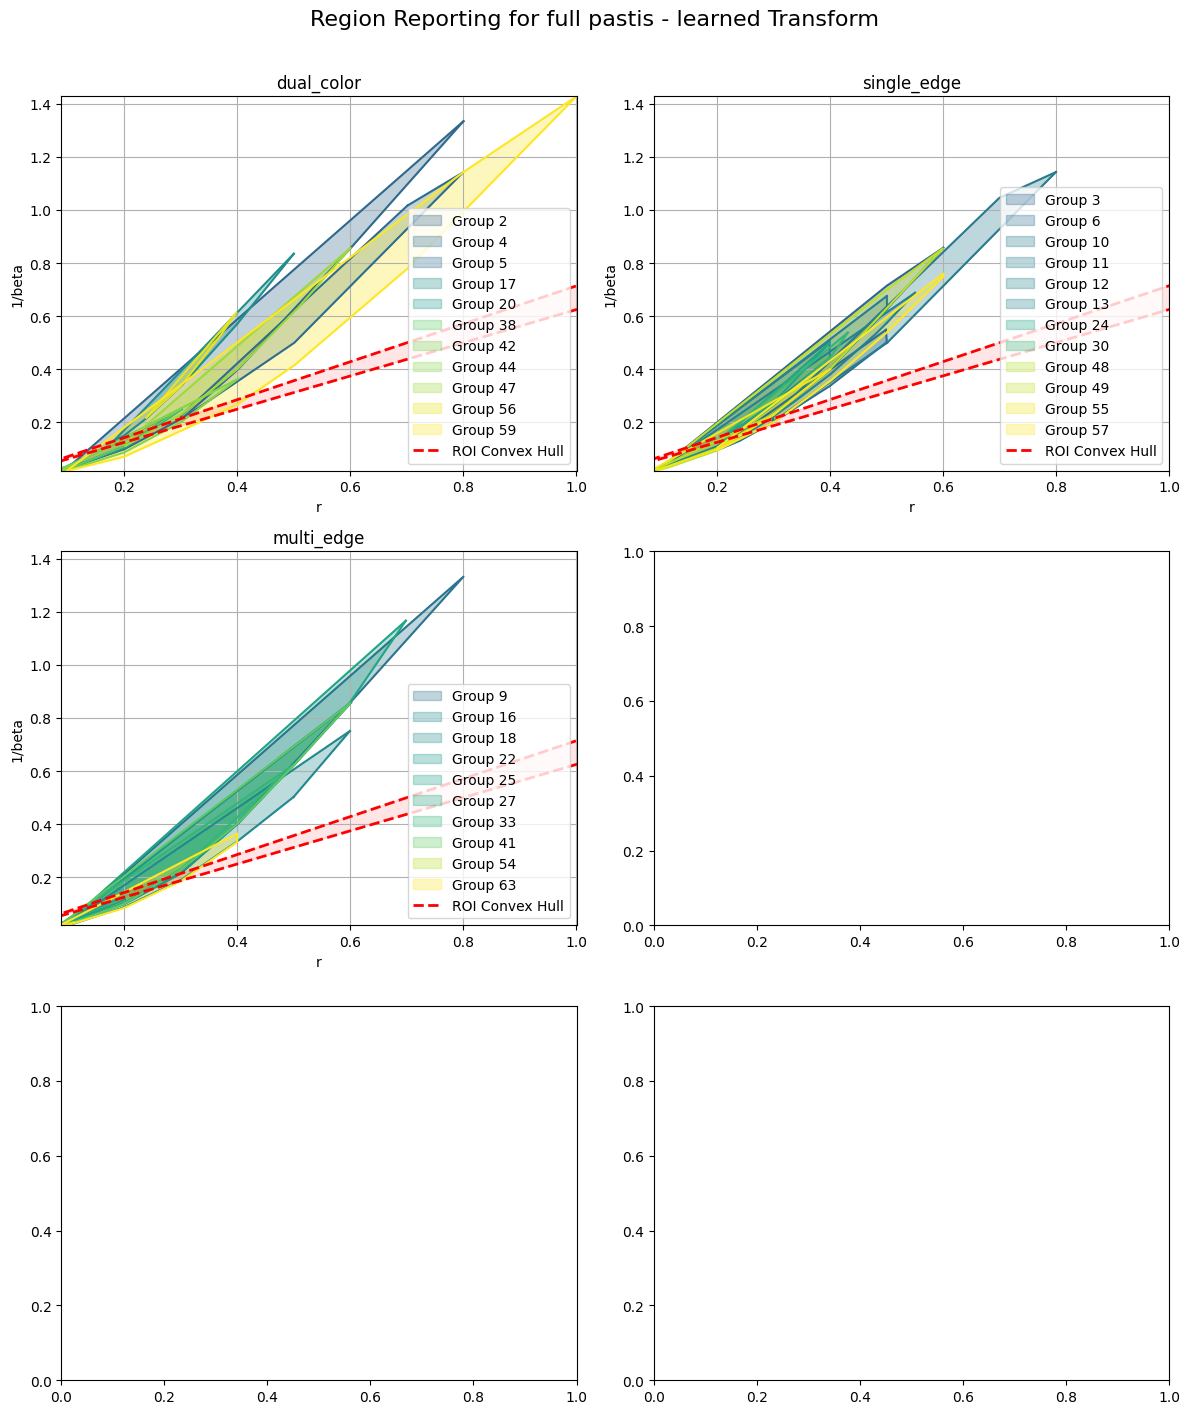

In [24]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

## agriVision

### Wavelet

In [25]:
DATASET = "agriVision"
SUBSET = "full"
TRANSFORM = "wavelet"
ORIENTATION = ["horizVert", "diagonal"]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

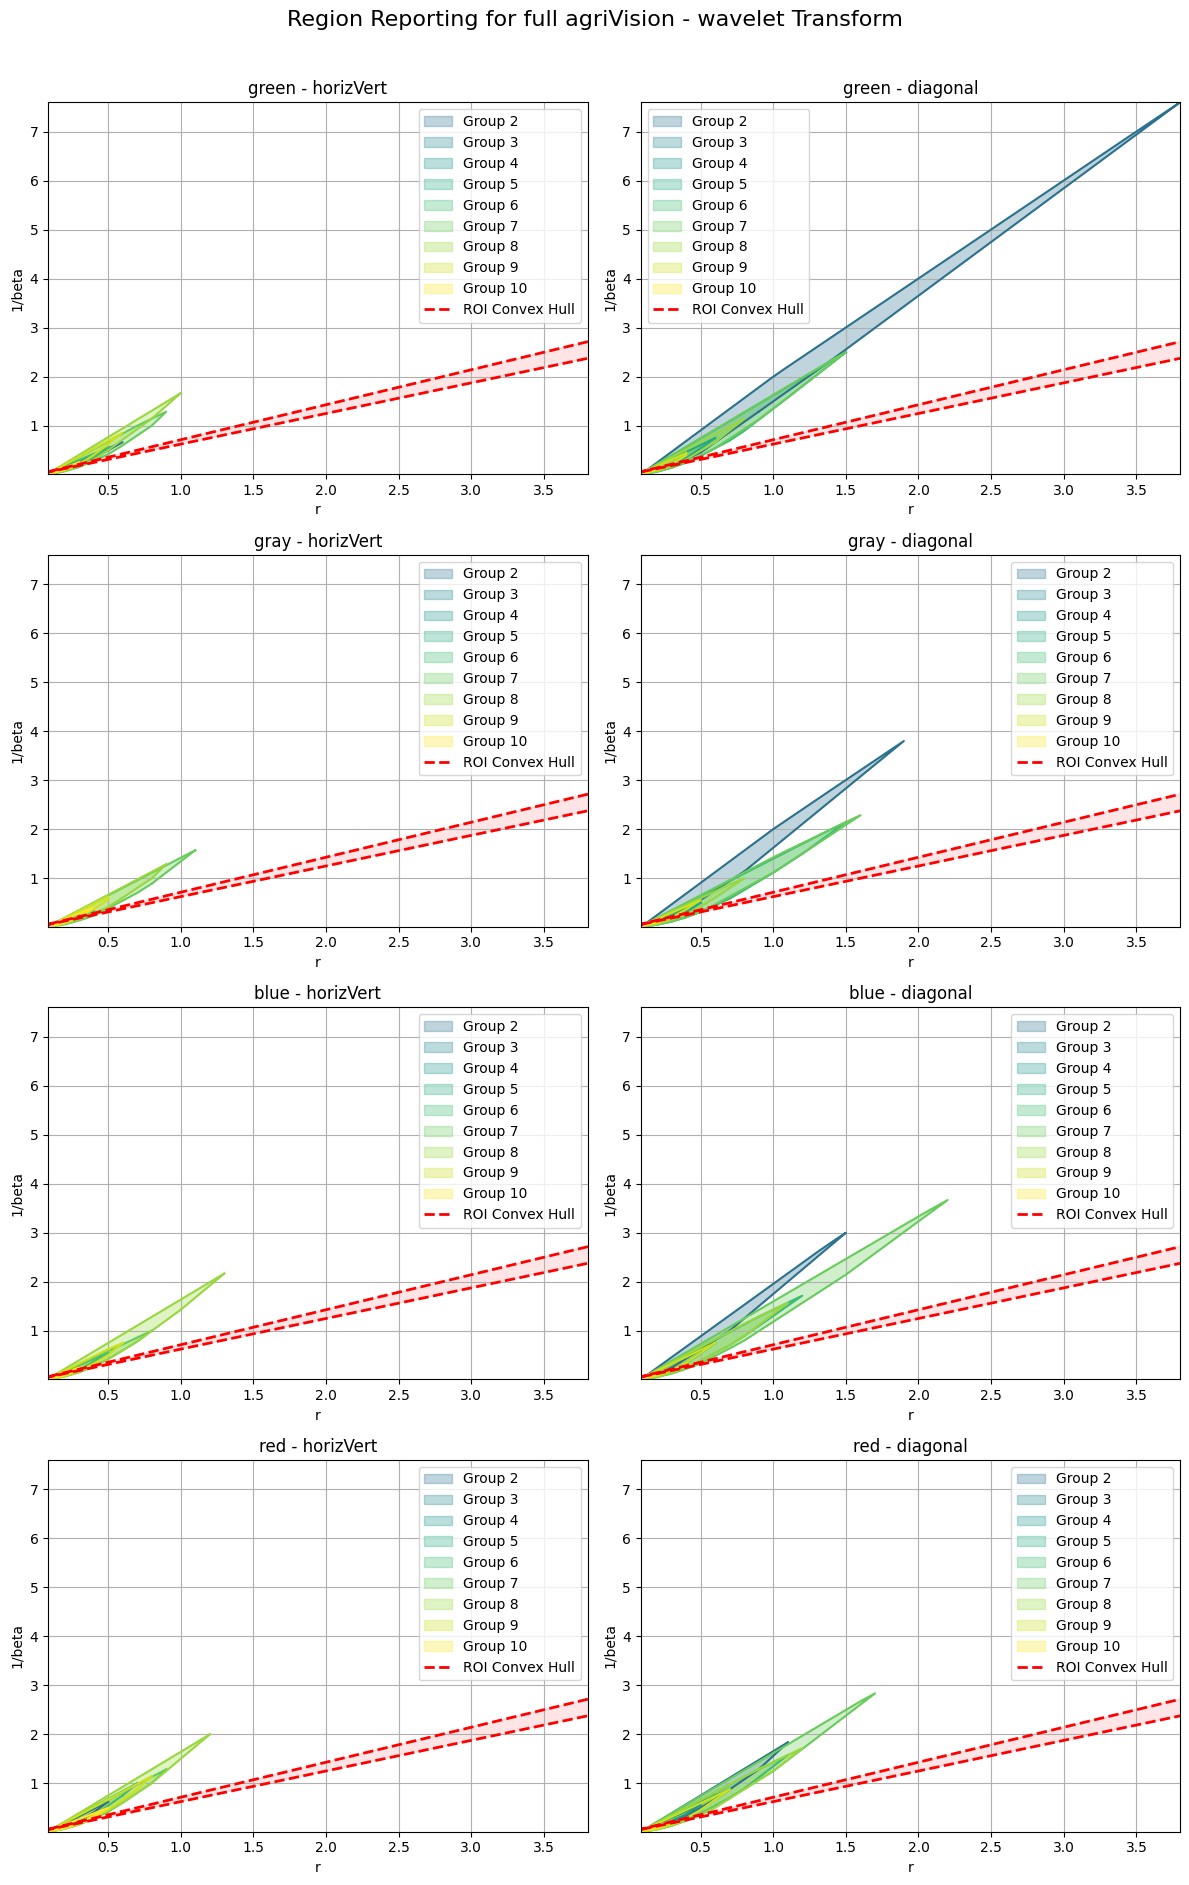

In [26]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

### Fourier

In [27]:
DATASET = "agriVision"
SUBSET = "full"
TRANSFORM = "fourier"
ORIENTATION = [np.nan]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

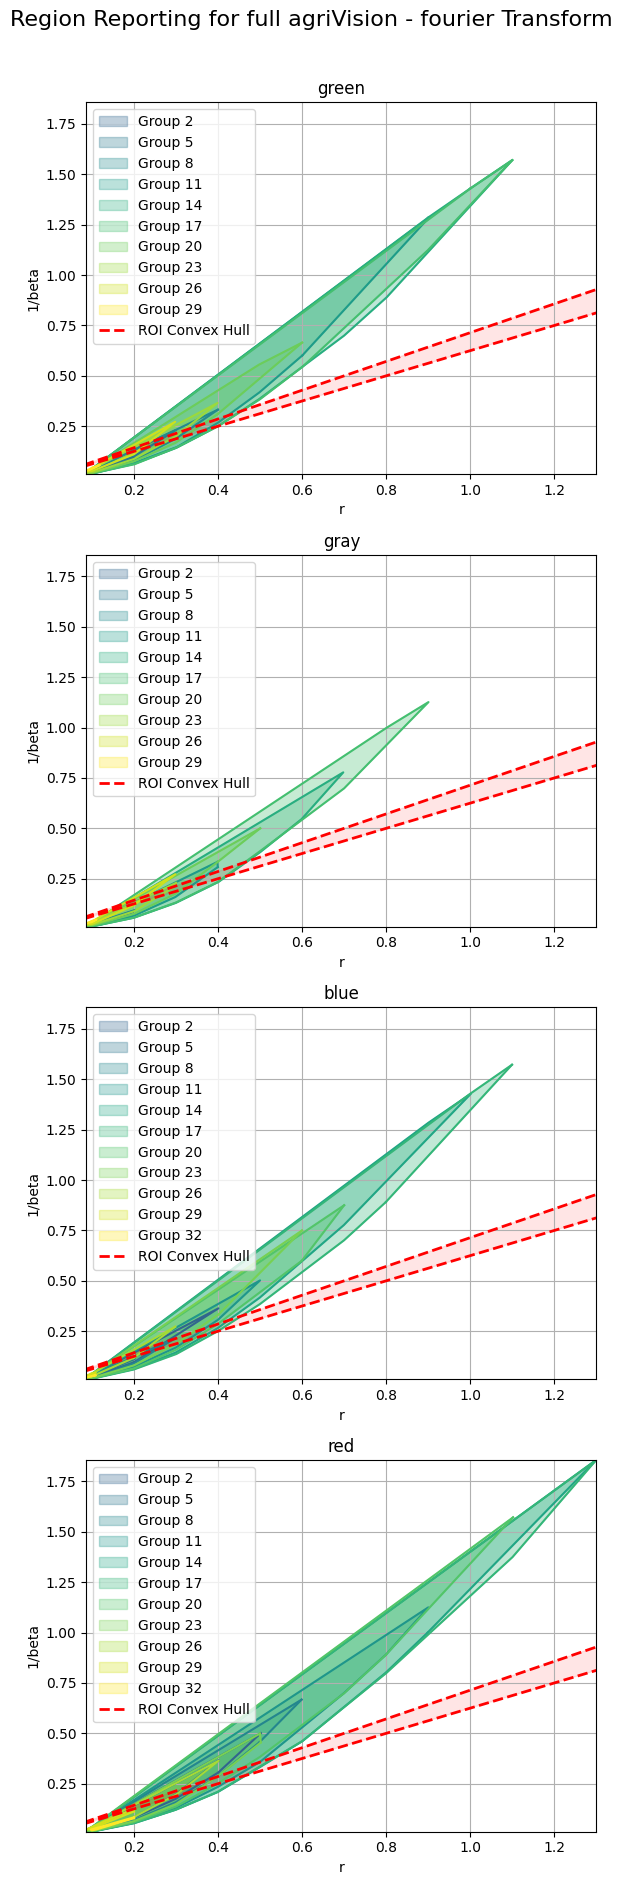

In [28]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

### Learned

In [29]:
DATASET = "agriVision"
SUBSET = "full"
TRANSFORM = "learned"
ORIENTATION = ["single_edge", "multi_edge", "eye", "dual_color", "inside_out", "misc"]
CHANNEL = [np.nan]
ZOOM  = False
PASS_ONLY = True


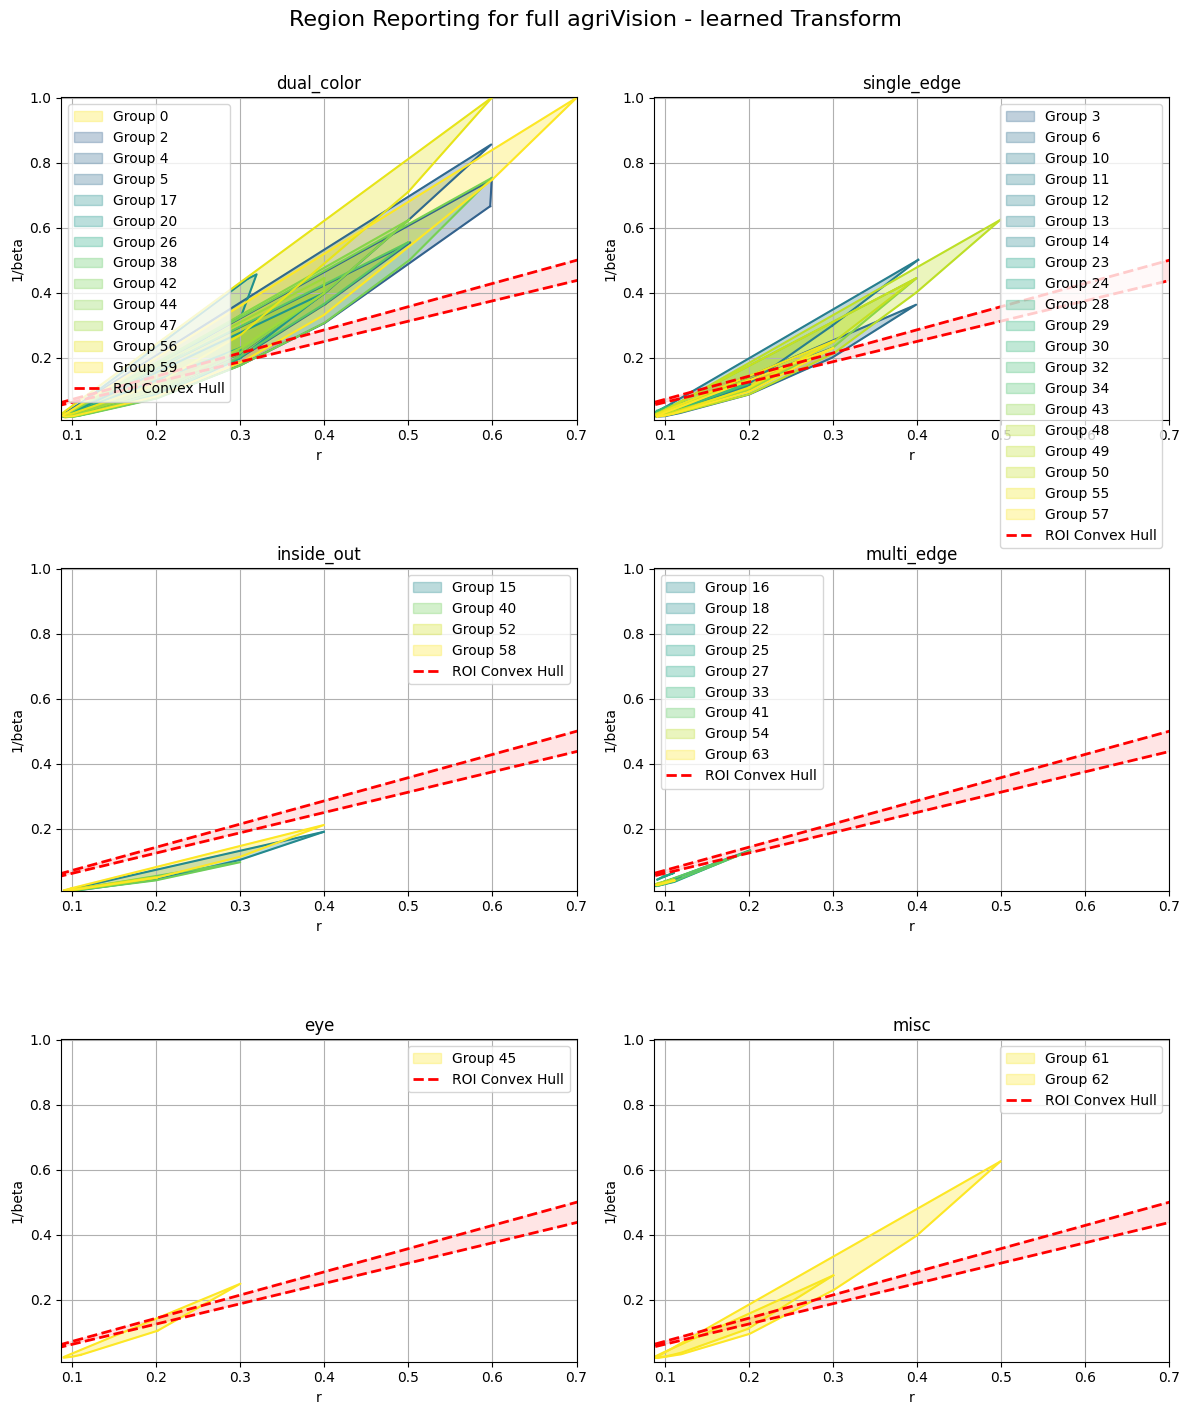

In [30]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

## spaceNet

### Wavelet

In [31]:
DATASET = "spaceNet"
SUBSET = "full"
TRANSFORM = "wavelet"
ORIENTATION = ["horizVert", "diagonal"]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

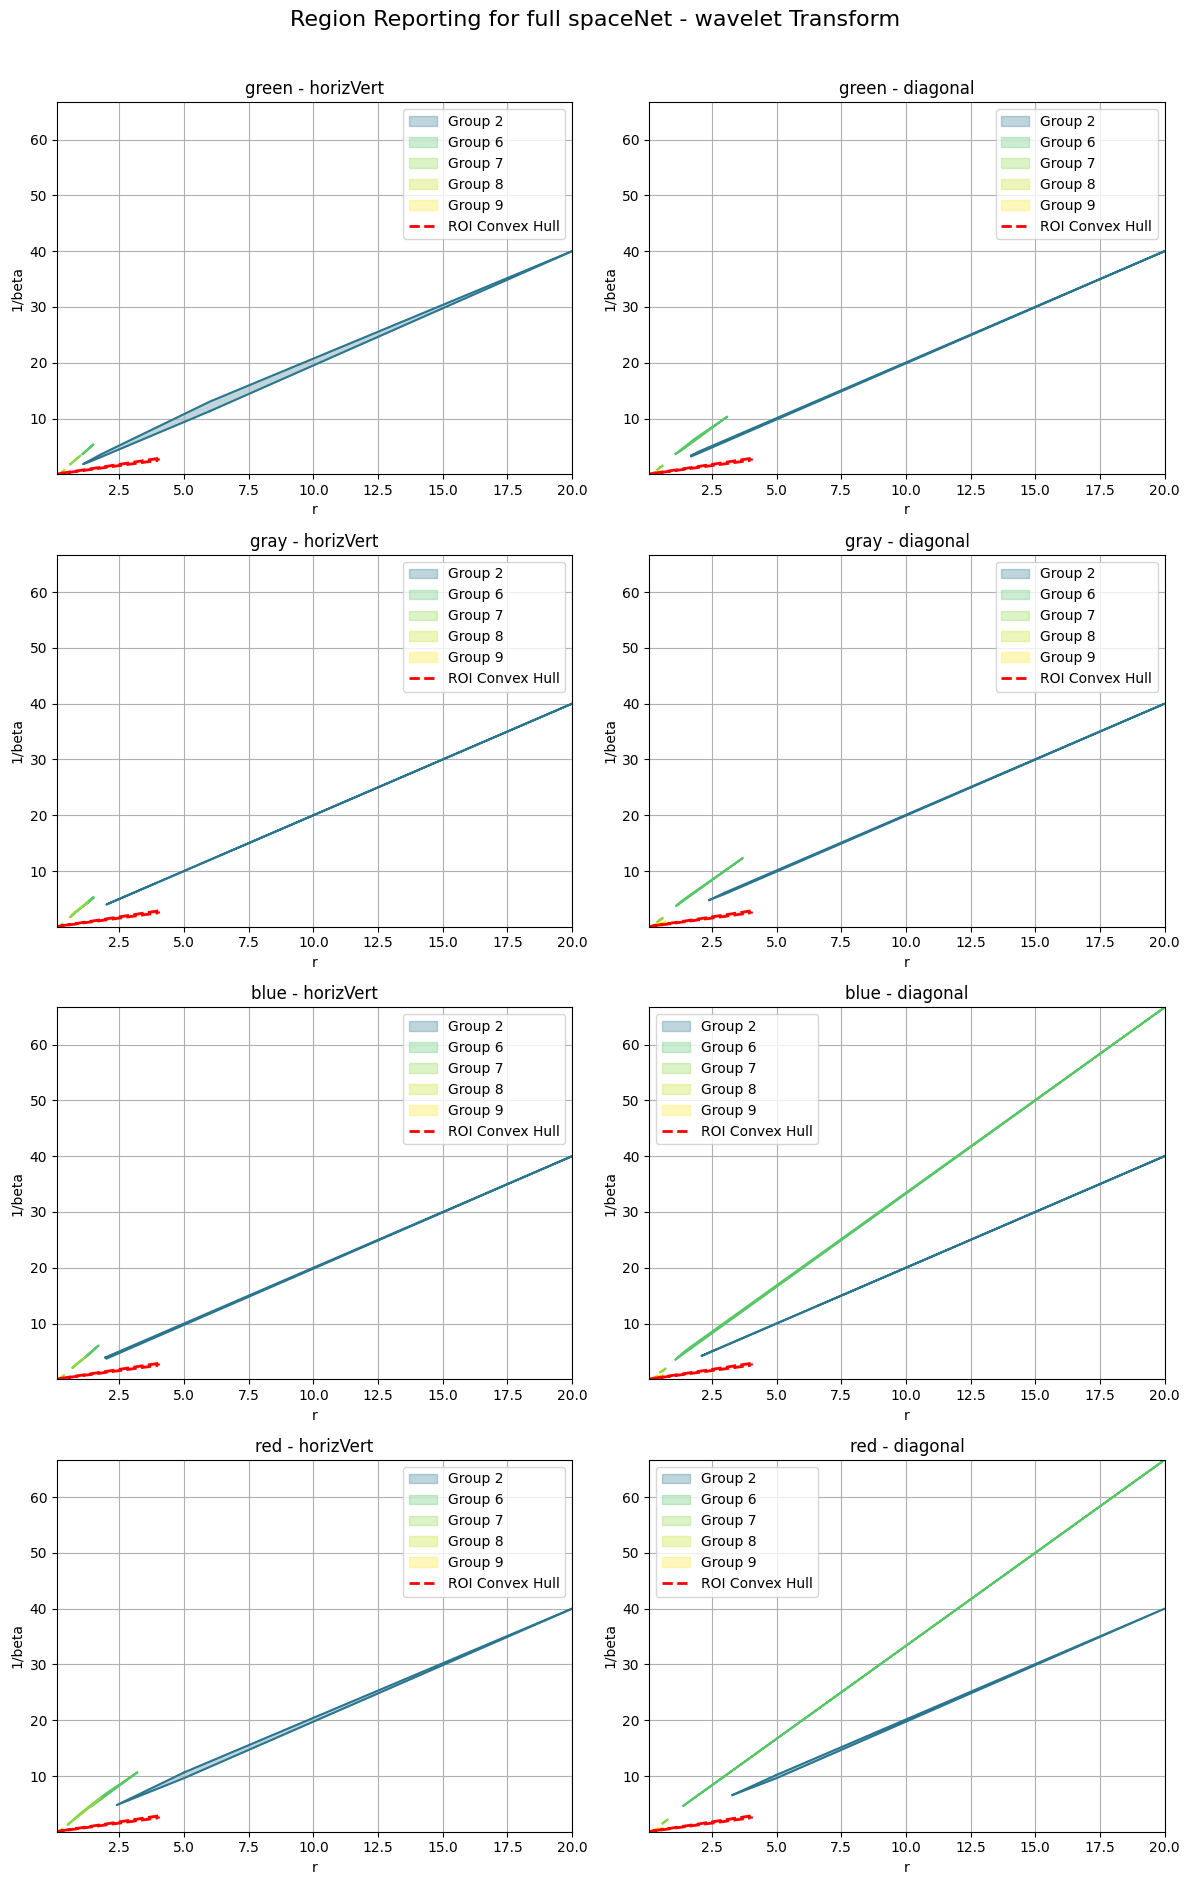

In [32]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

### Fourier

In [33]:
DATASET = "spaceNet"
SUBSET = "full"
TRANSFORM = "fourier"
ORIENTATION = [np.nan]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

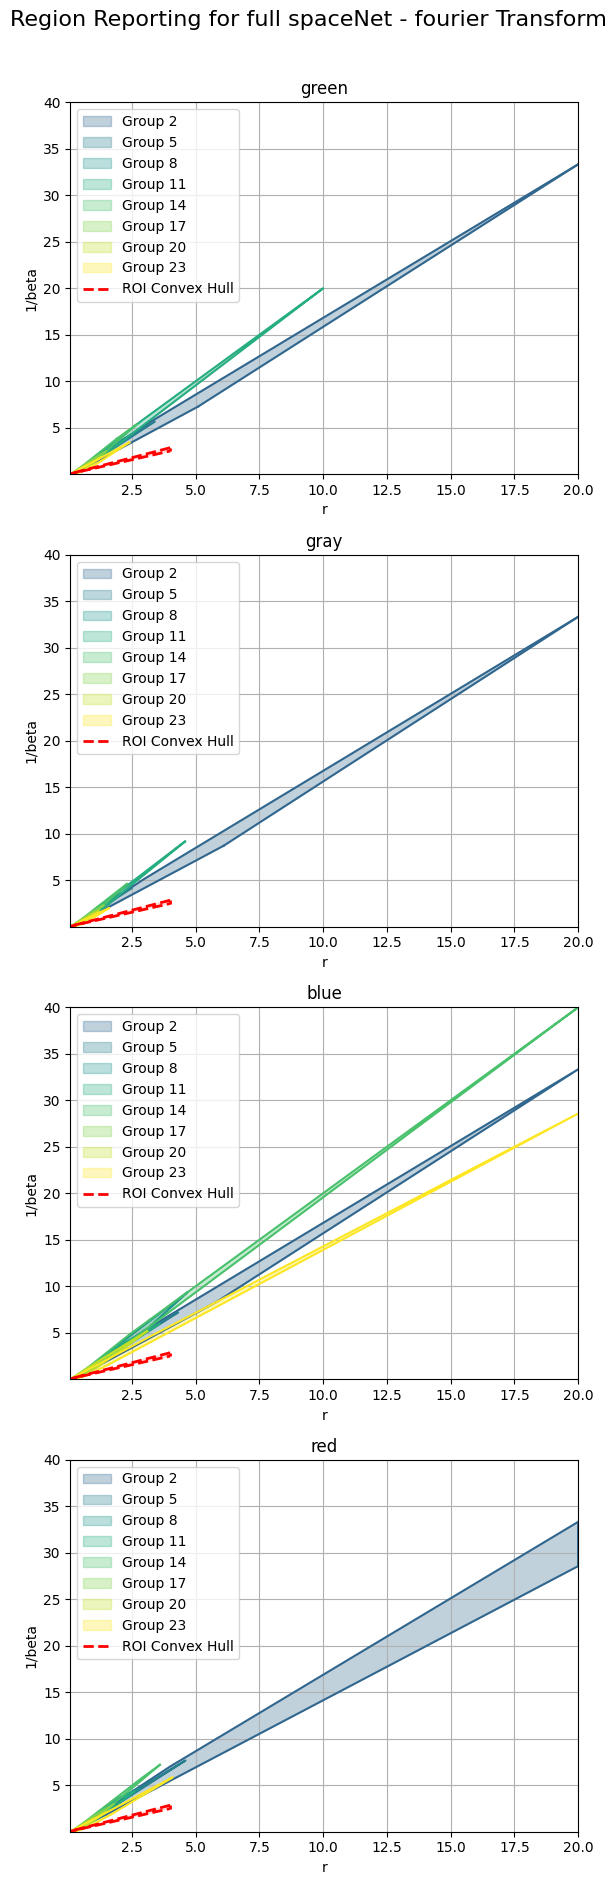

In [34]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

### Learned

In [35]:
DATASET = "spaceNet"
SUBSET = "full"
TRANSFORM = "learned"
ORIENTATION = ["single_edge", "multi_edge", "eye", "dual_color", "inside_out", "misc"]
CHANNEL = [np.nan]
ZOOM  = False
PASS_ONLY = True


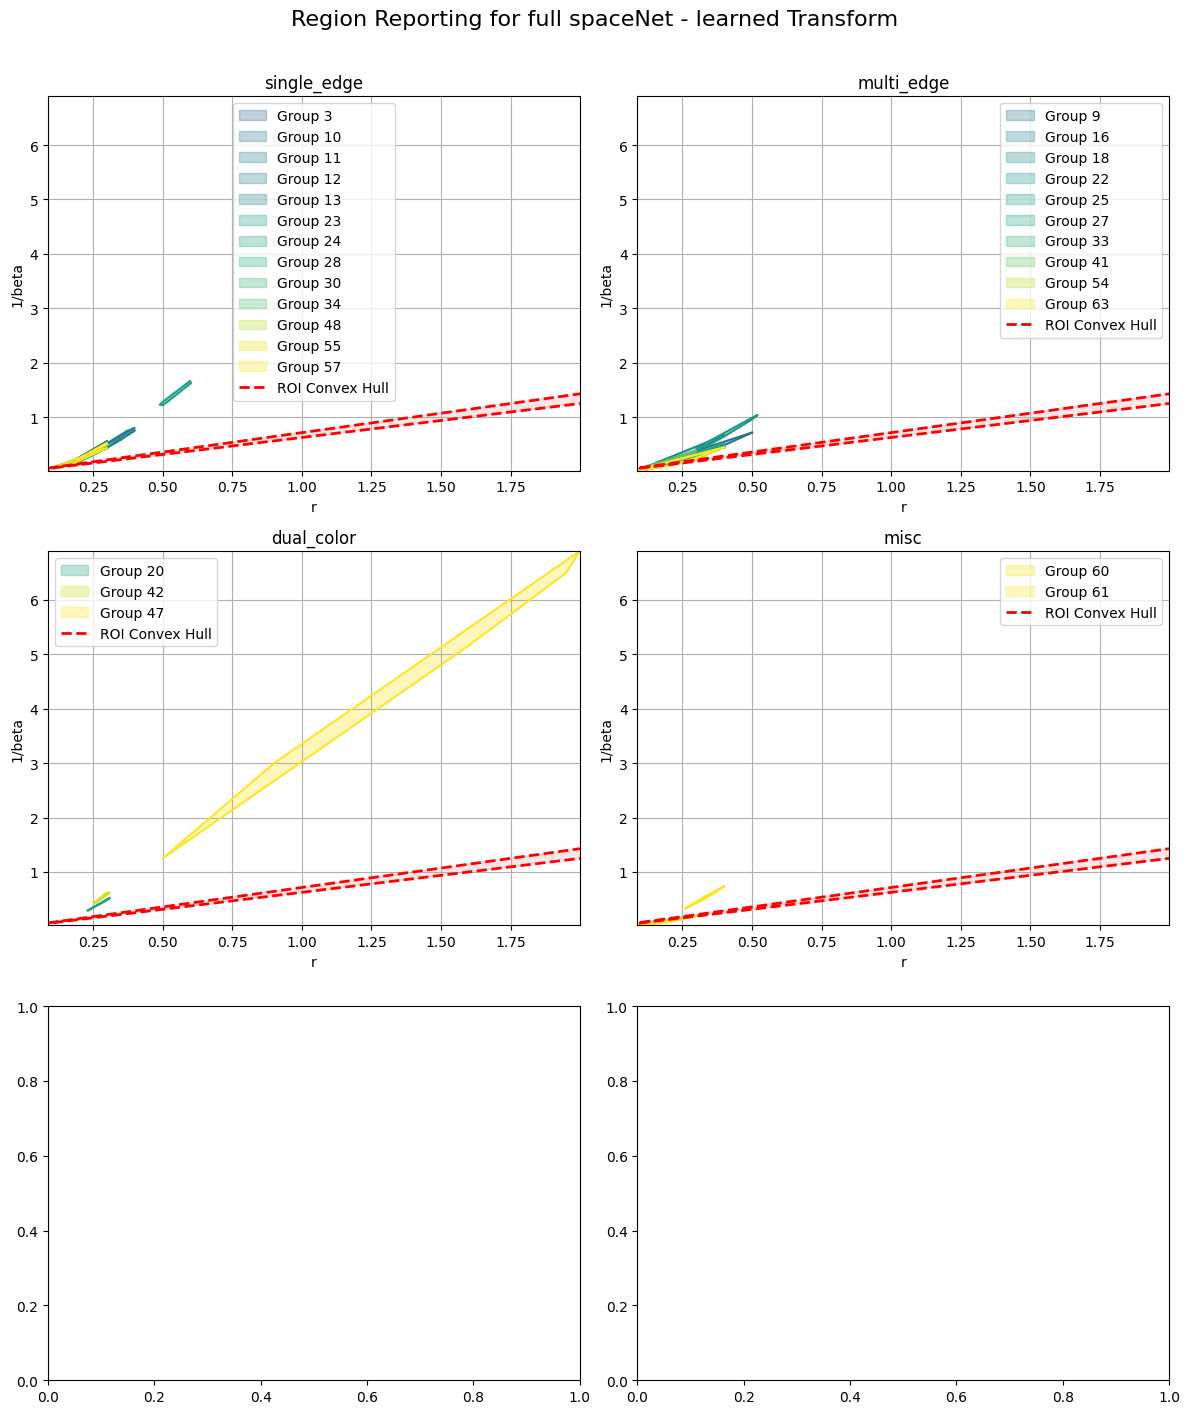

In [36]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

# Natural Images

## coco

### Indoor

#### Wavelet

In [37]:
DATASET = "coco"
SUBSET = "indoor"
TRANSFORM = "wavelet"
ORIENTATION = ["horizontal", "vertical", "diagonal"]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

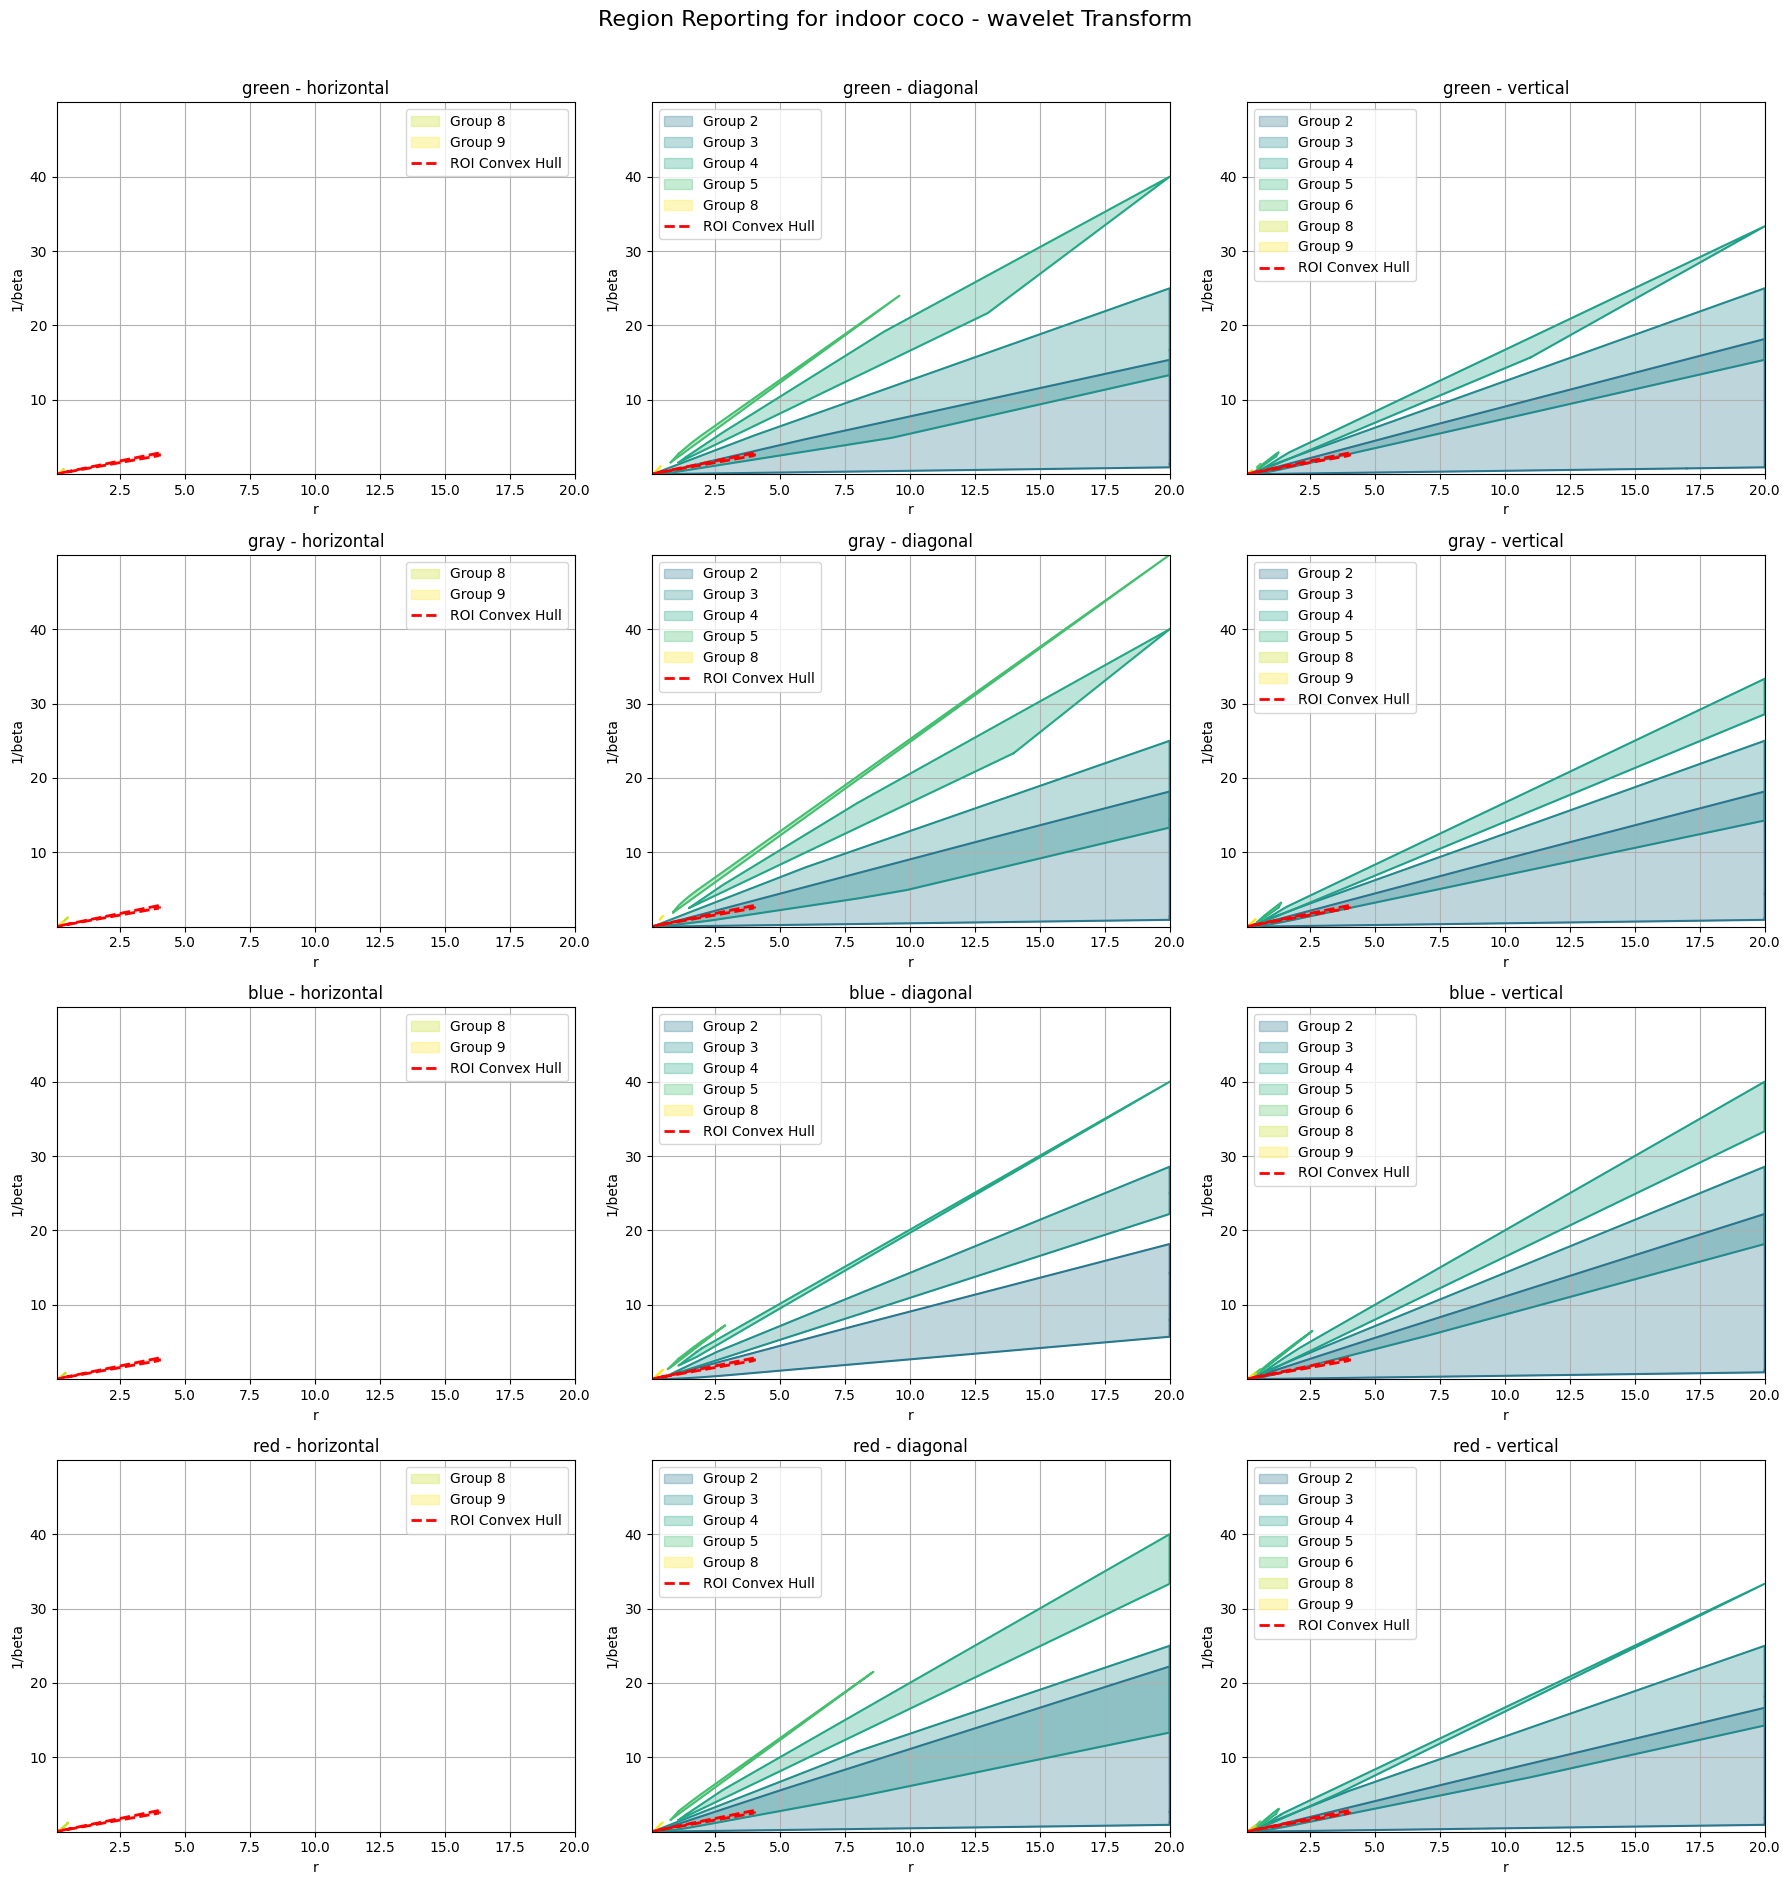

In [38]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

#### Learned

In [39]:
DATASET = "coco"
SUBSET = "indoor"
TRANSFORM = "learned"
ORIENTATION = ["single_edge", "multi_edge", "eye", "dual_color", "inside_out", "misc"]
CHANNEL = [np.nan]
ZOOM  = False
PASS_ONLY = True


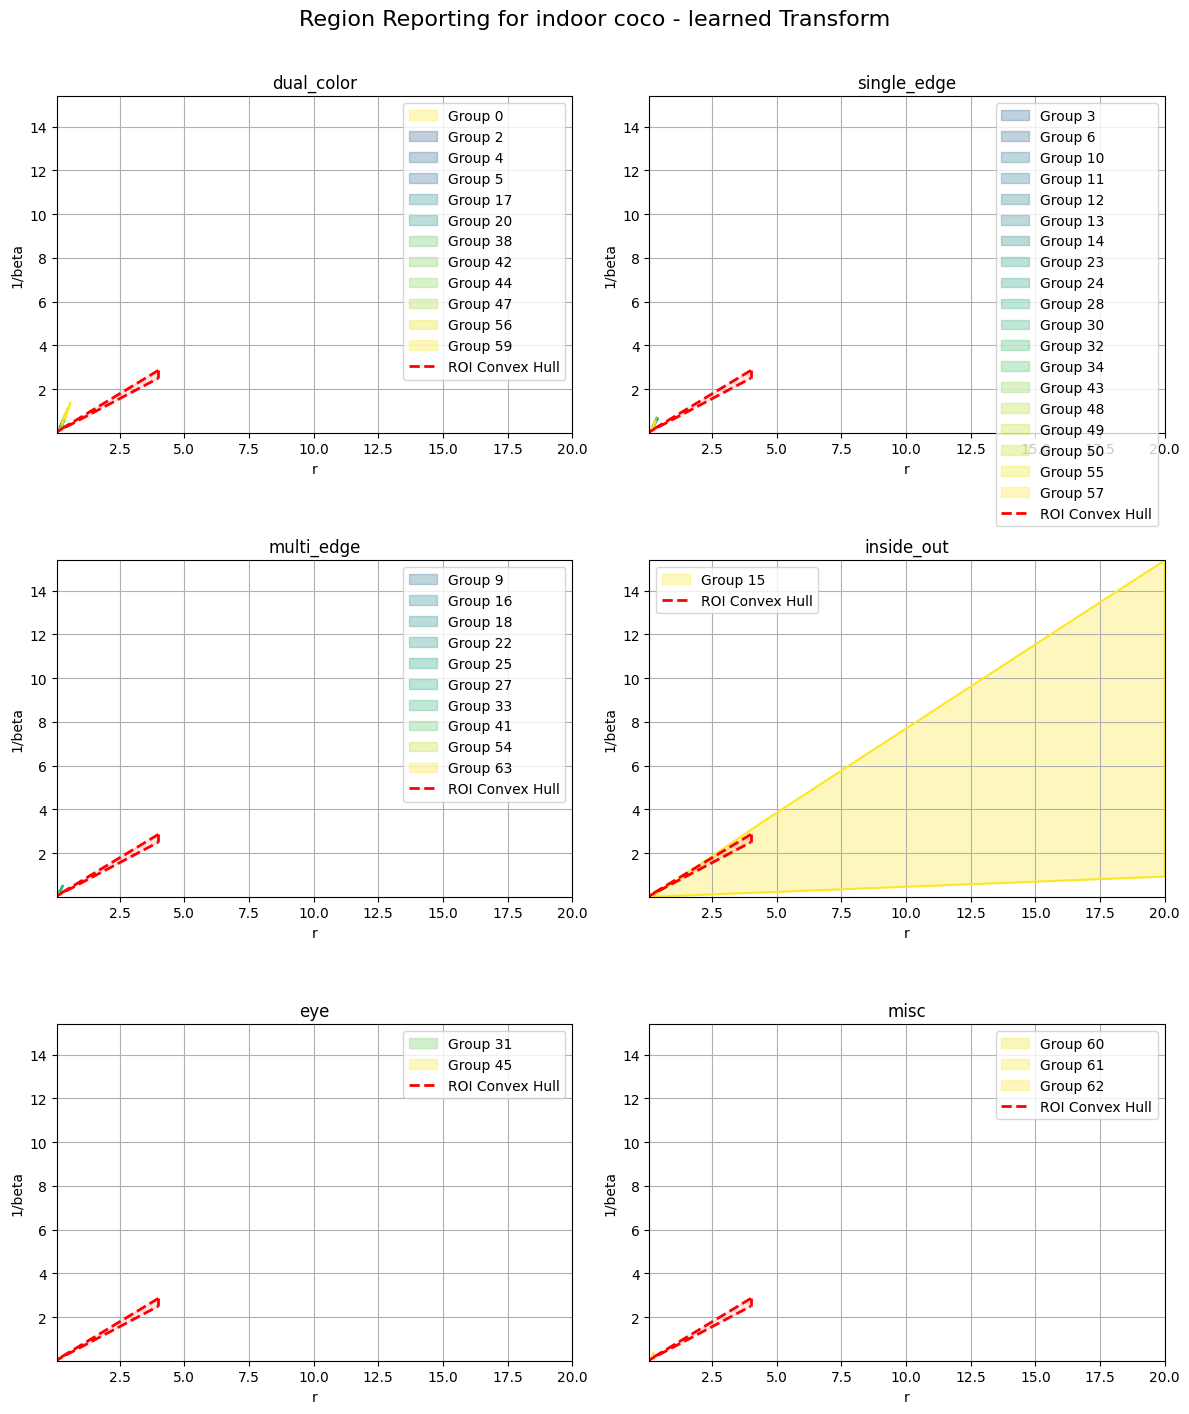

In [40]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

### Outdoor

#### Indoor

In [41]:
DATASET = "coco"
SUBSET = "outdoor"
TRANSFORM = "wavelet"
ORIENTATION = ["horizontal", "vertical", "diagonal"]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

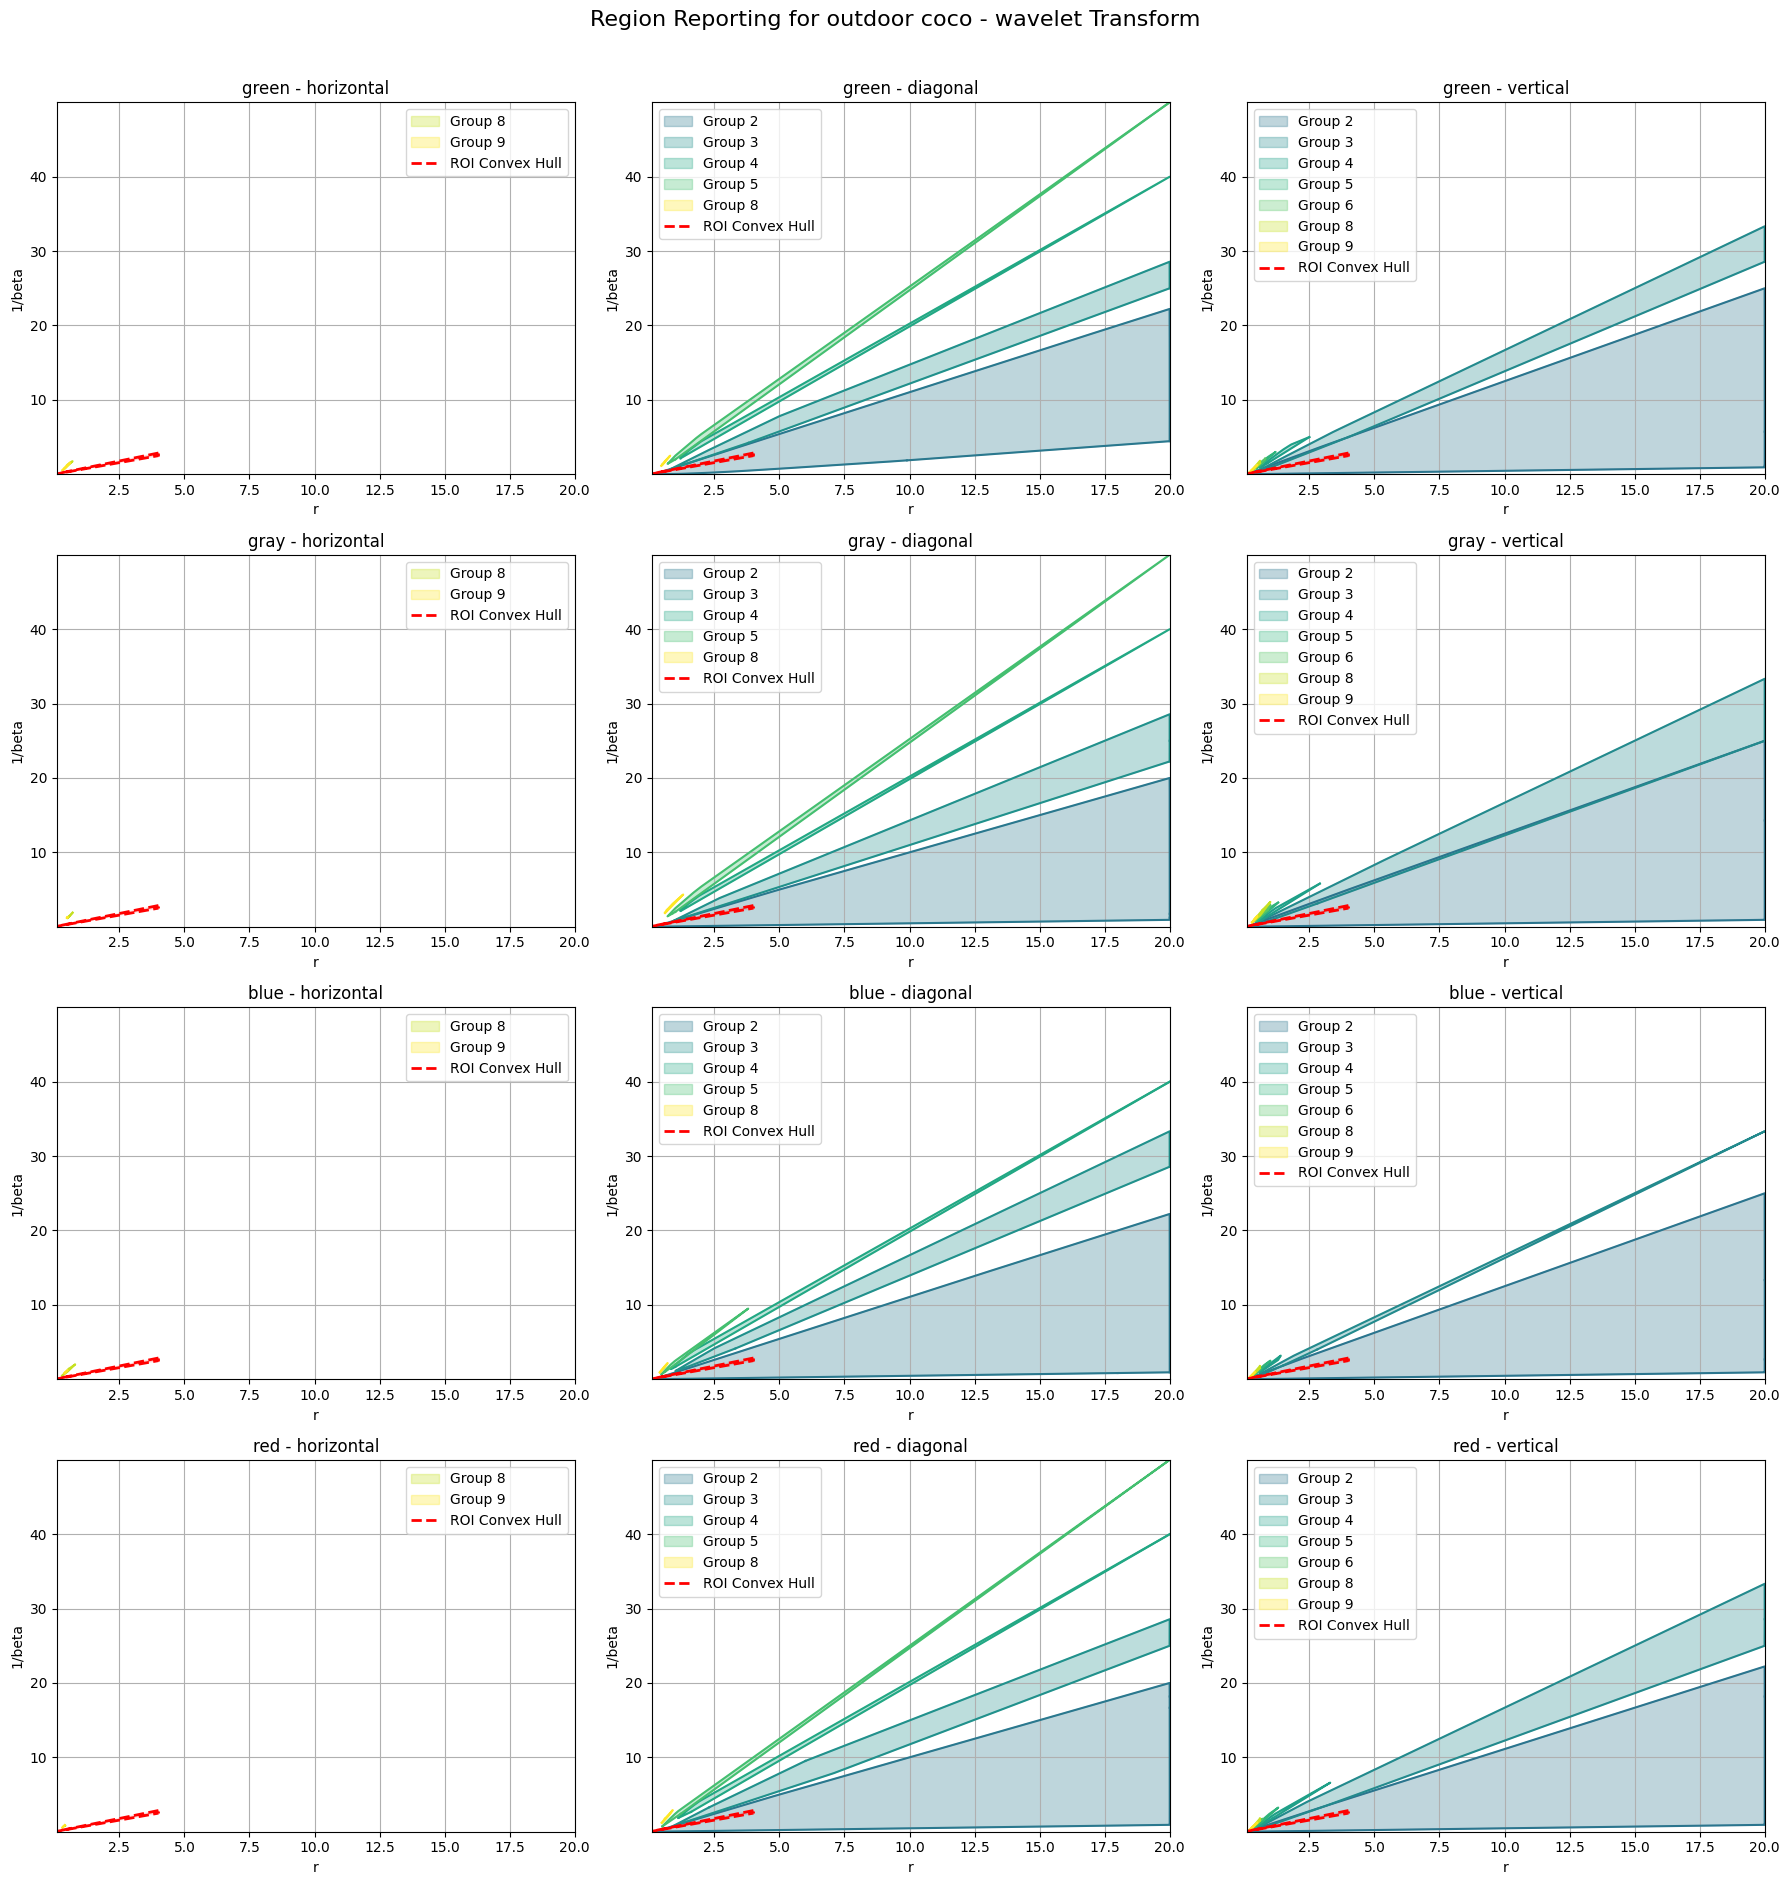

In [42]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

#### Learned

In [43]:
DATASET = "coco"
SUBSET = "outdoor"
TRANSFORM = "learned"
ORIENTATION = ["single_edge", "multi_edge", "eye", "dual_color", "inside_out", "misc"]
CHANNEL = [np.nan]
ZOOM  = False
PASS_ONLY = True


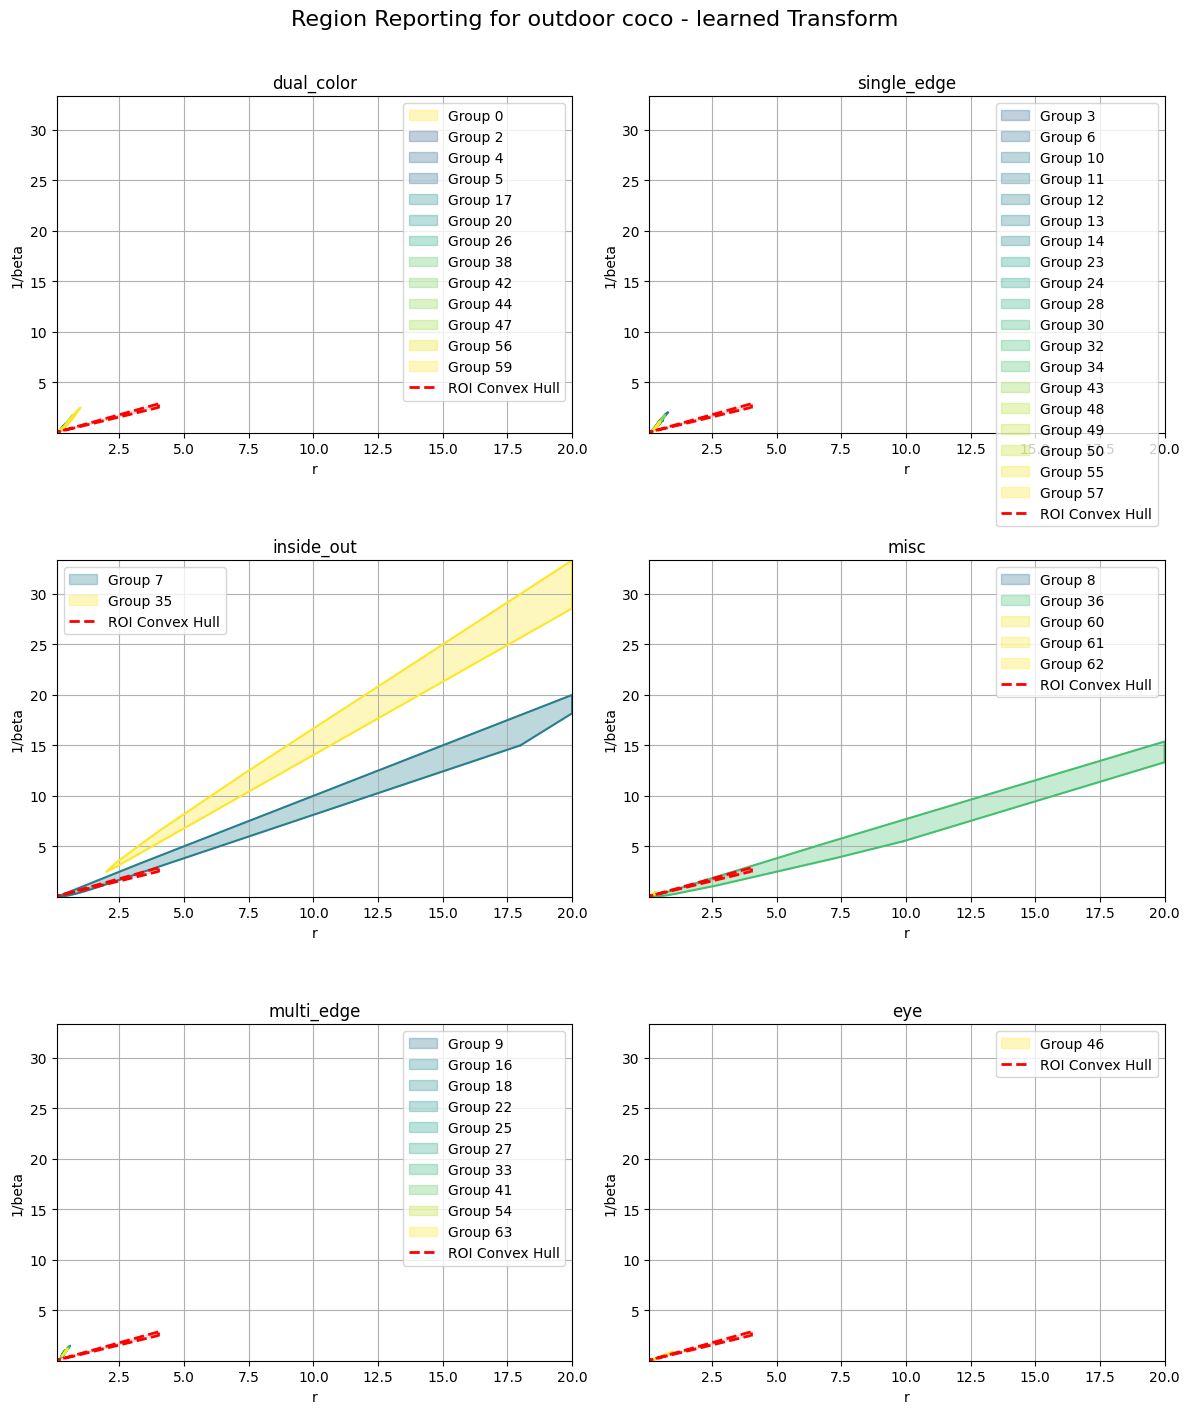

In [44]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

## segmentAnything

### wavelet

In [45]:
DATASET = "segmentAnything"
SUBSET = "full"
TRANSFORM = "wavelet"
ORIENTATION = ["horizontal", "vertical", "diagonal"]
CHANNEL = ["gray","red", "blue", "green"]
ZOOM  = False
PASS_ONLY = True

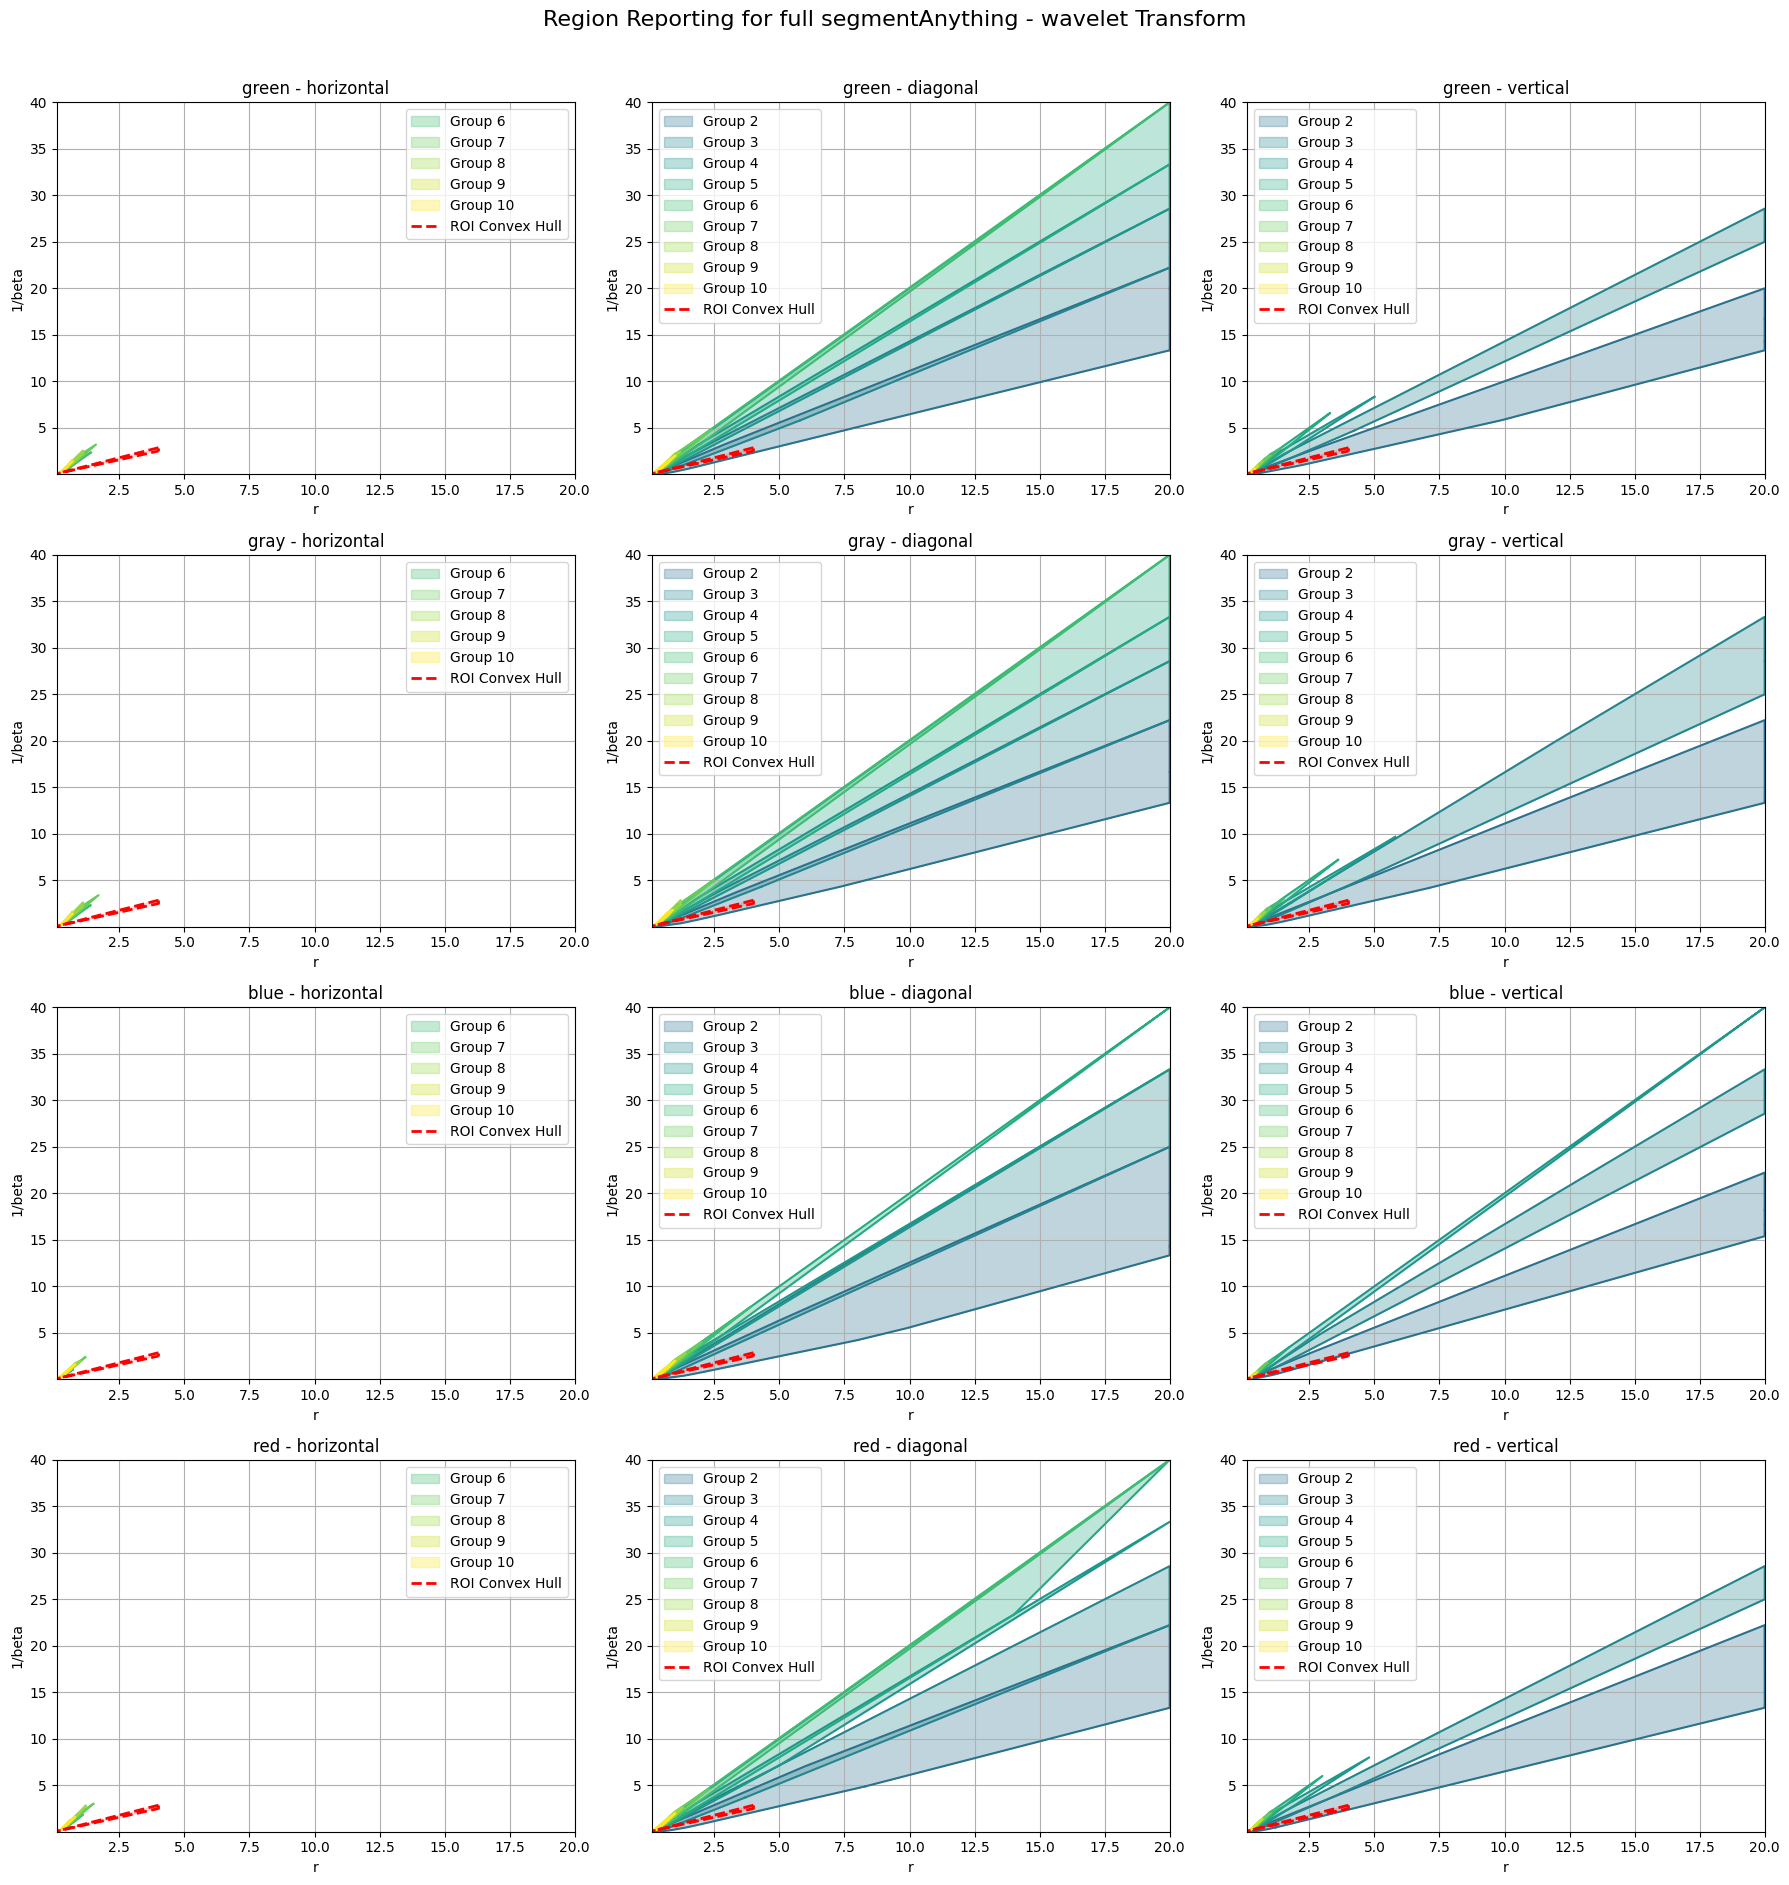

In [46]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

### Learned

In [47]:
DATASET = "segmentAnything"
SUBSET = "full"
TRANSFORM = "learned"
ORIENTATION = ["single_edge", "multi_edge", "eye", "dual_color", "inside_out", "misc"]
CHANNEL = [np.nan]
ZOOM  = False
PASS_ONLY = True


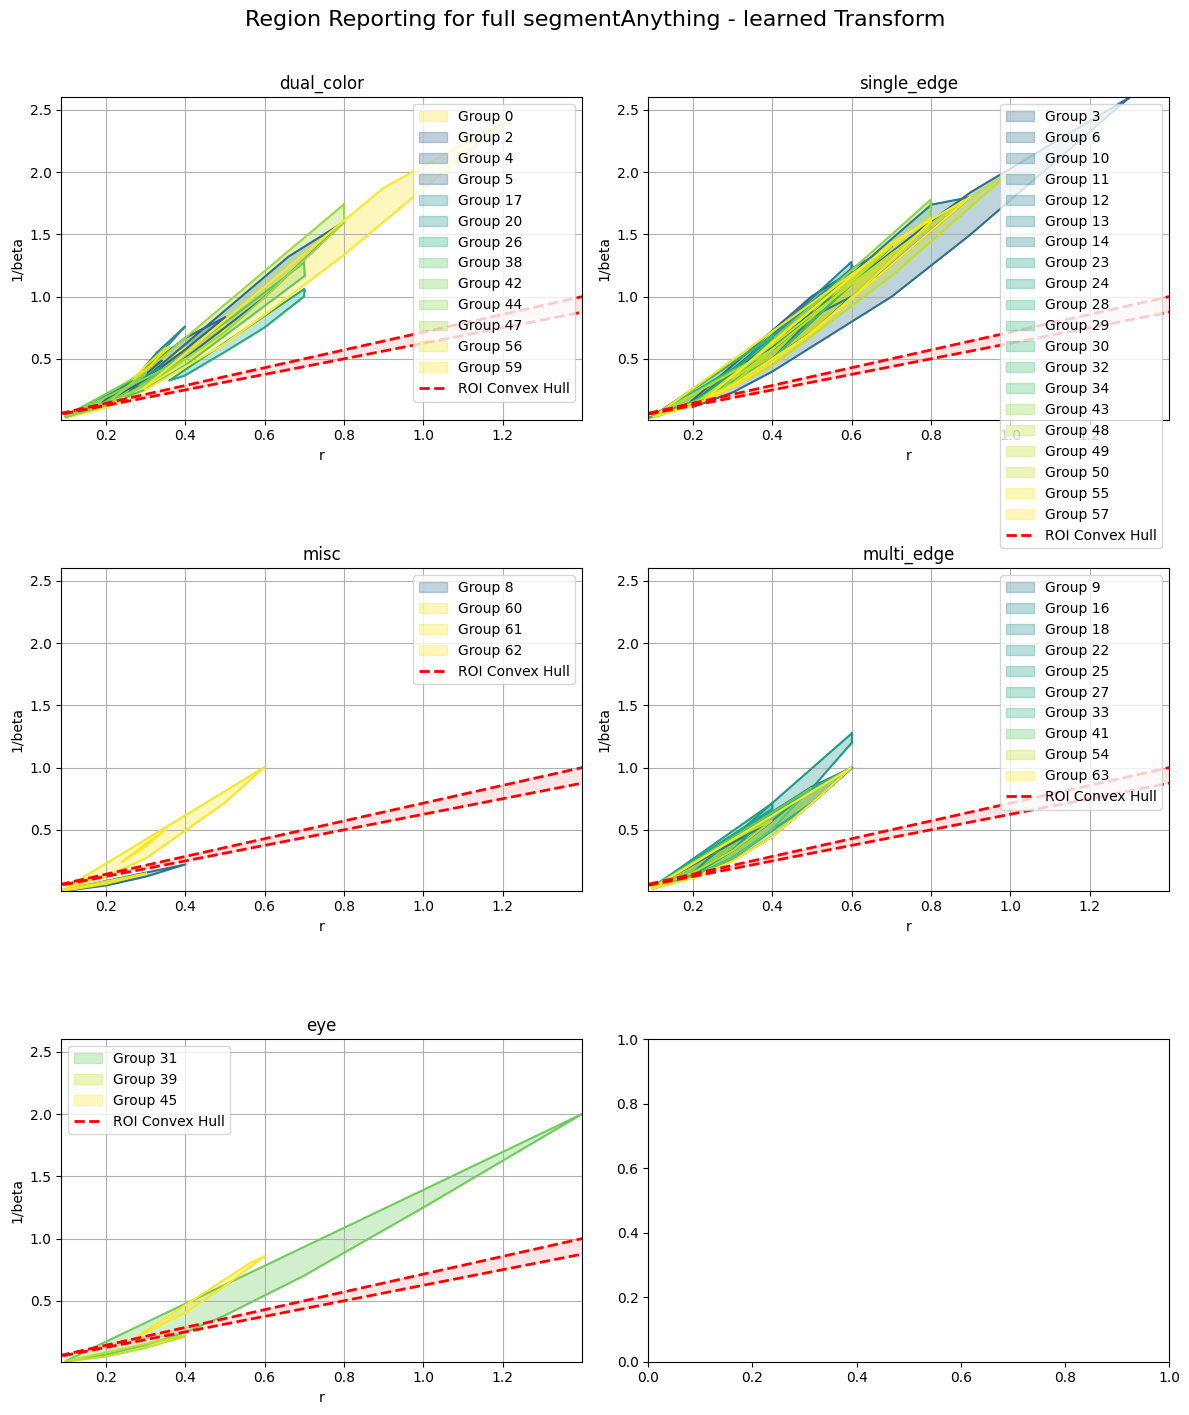

In [48]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

# MRI

## syntheticMRI2D

In [49]:
DATASET = "syntheticMRI2D"
TYPE = "MRI"
SUBSET = ""
TRANSFORM = "wavelet"
ORIENTATION = ["horizontal", "diagonal", "vertical"]
CHANNEL = ["coronal", "axial", "sagittal"]
ZOOM  = False
PASS_ONLY = True

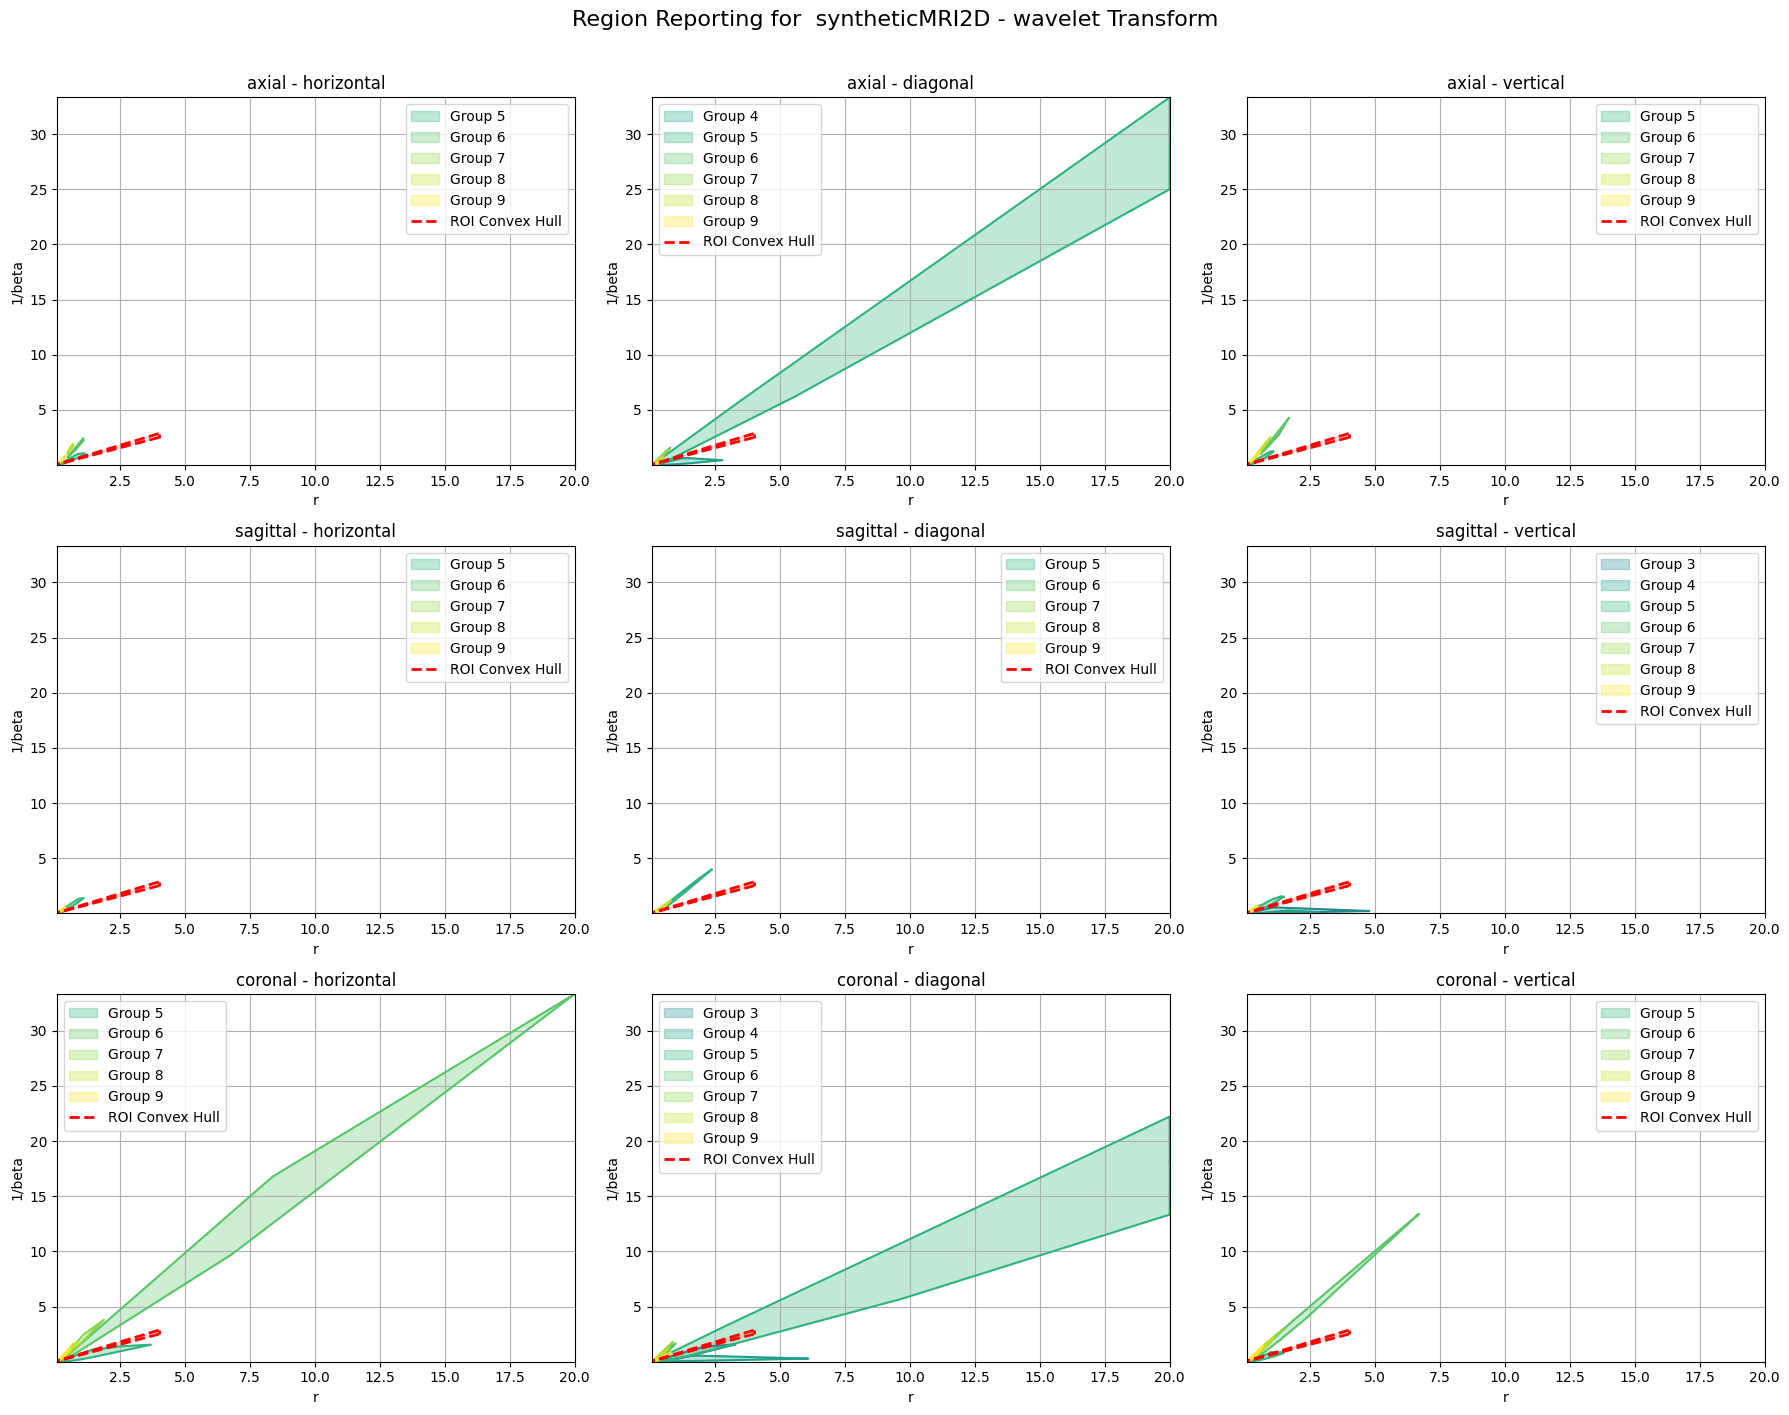

In [50]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)

## syntheticMRI3D

In [51]:
DATASET = "syntheticMRI3D"
SUBSET = "full"
TRANSFORM = "wavelet"
ORIENTATION = ["aad", "ada", "add","daa", "dad", "dda", "ddd"]
CHANNEL = [np.nan]
ZOOM  = False
PASS_ONLY = True

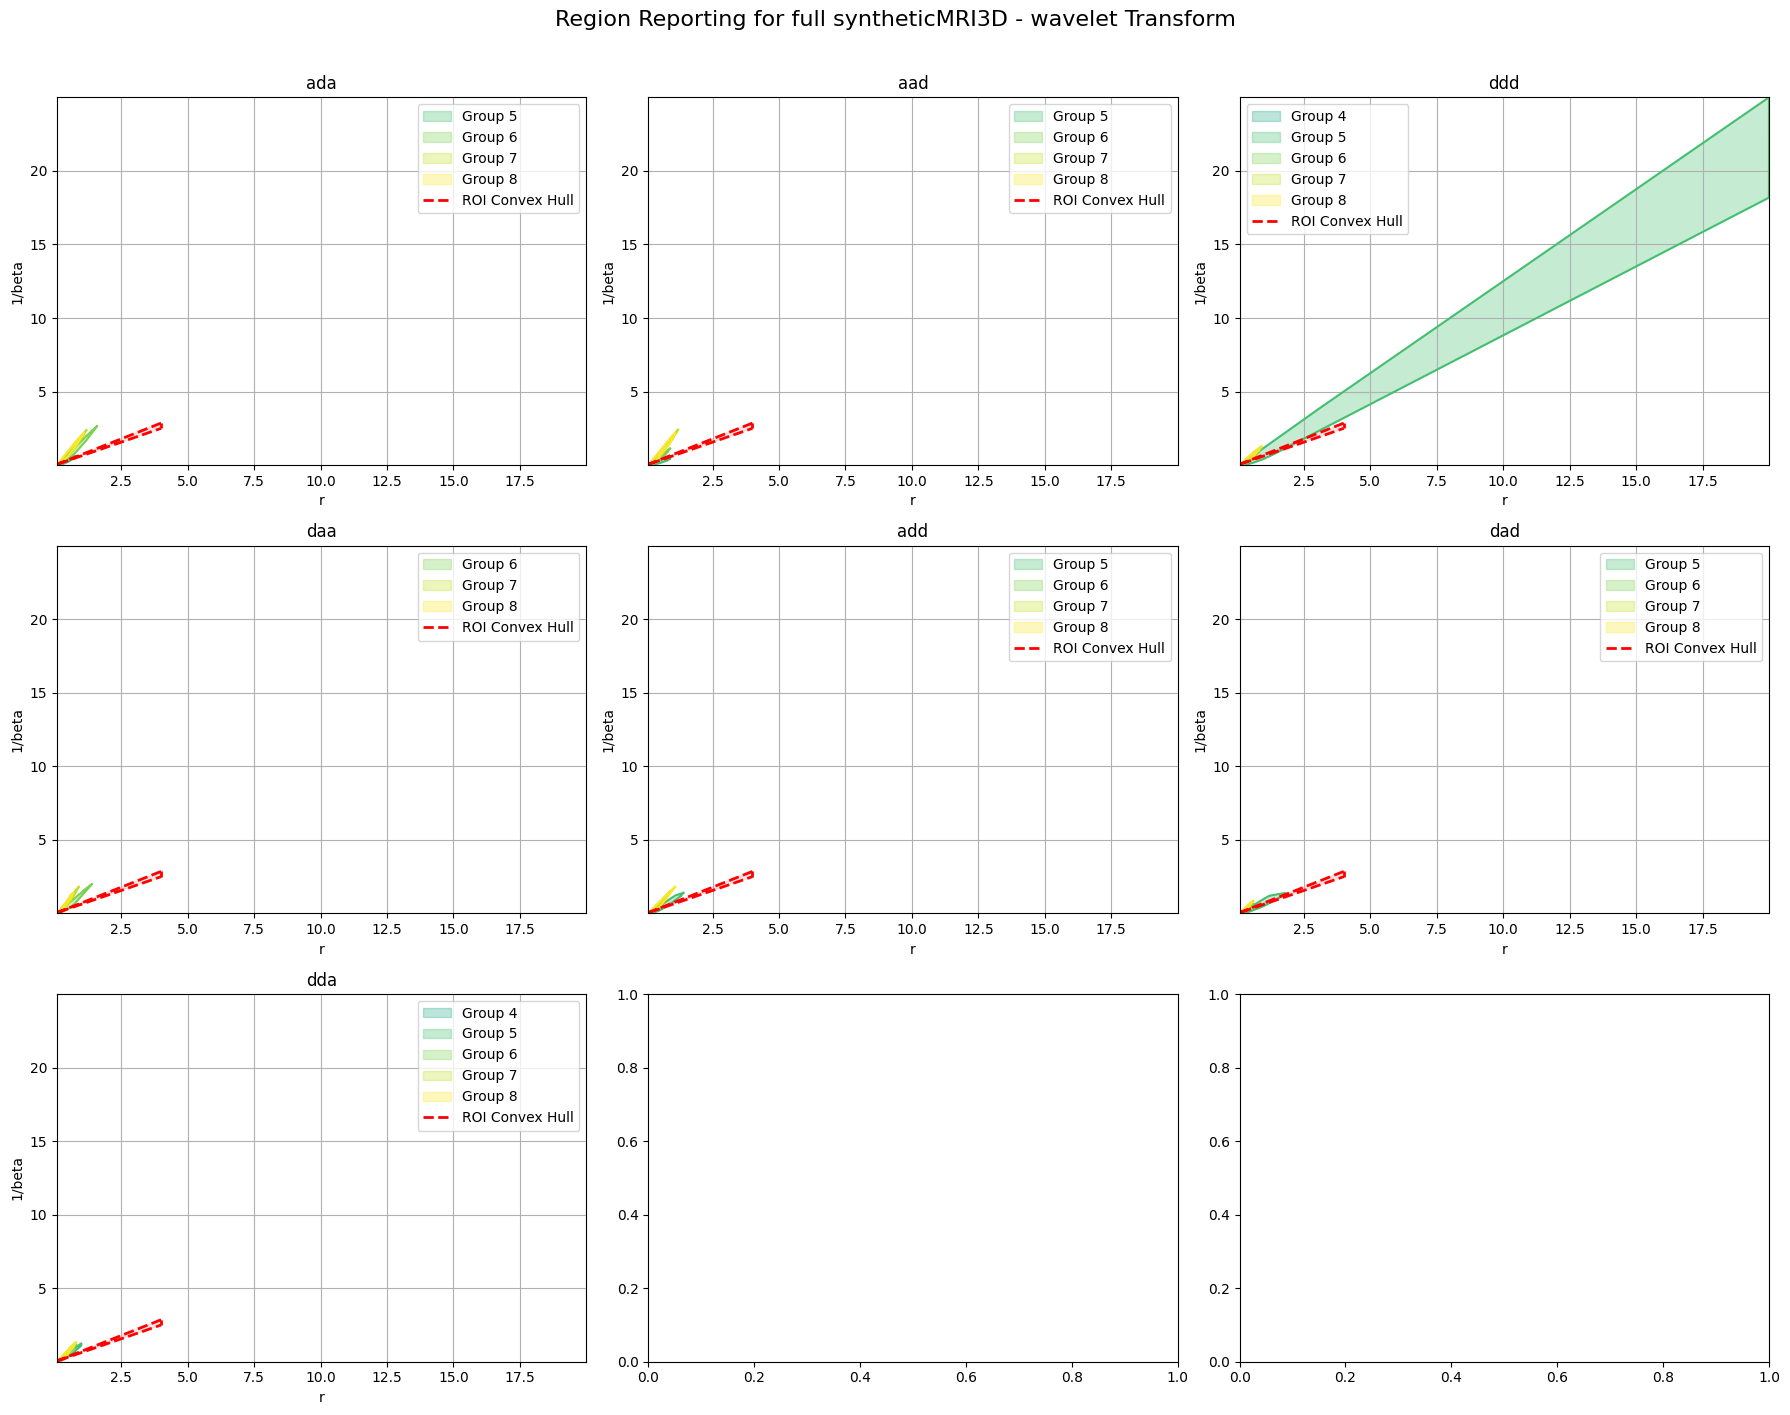

In [52]:
if DATASET == "syntheticMRI2D":
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['transform'] == TRANSFORM)].copy()
    temp_df["channel"] = temp_df["subset"]
else:
    temp_df = main_df[(main_df['dataset'] == DATASET) & (main_df['subset'] == SUBSET) & (main_df['transform'] == TRANSFORM)].copy()
if PASS_ONLY:
    temp_df = temp_df[temp_df["failure_type"] == "pass"]
# Prepare hull points for global min/max
generate_hull_plots(temp_df)